# <center> Classification of Pneumonia using Deep Autoencoder for Chest X-ray images
<center> Faculty of Engineering, University of Porto Master in Data Science and Enginnering

<center> Karim Kousa up202102687 | Silvia Tavares up202204392 | Sónia Ferreira up202200967 | Francisco Cuervo up202302145

<center> Advanced Topics in Machine Learning

## Introduction

More than 1 million adults are hospitalized with pneumonia and around 50,000 die from the disease every year in the US alone (CDC, 2017). Pneumonia is a respiratory disease that causes inflammation in one or both lungs, resulting in symptoms such as cough, fever, and difficulty breathing. Early detection of pneumonia is essential for effective treatment and improved patient outcomes. Unfortunately, pneumonia is just one of several lung diseases, thus radiographic results do not always confirm a pneumonia diagnosis. Therefore, with current technology, it is impossible to distinguish pneumonia from other lung diseases with certainty using radiological criteria.

Developing accurate pneumonia detection algorithms requires large amounts of high-quality labeled data, which can be difficult to obtain. This is particularly challenging in the case of pneumonia, where expert radiologists are required to label the data, and the number of available labeled images is limited. Deep learning, a subset of artificial intelligence, has emerged as a powerful tool for detecting and diagnosing pneumonia from medical images such as chest X-rays.

Deep-learning algorithms can be trained on large datasets of chest X-rays to recognize patterns and features that are indicative of pneumonia. This involves using convolutional neural networks (CNNs), a type of deep-learning architecture that is particularly well suited to image recognition tasks. By analyzing the texture, shape, and intensity of pixels in chest X-rays, CNNs can learn to identify regions of the image that correspond to areas of infection or inflammation in the lungs.

Once trained, deep-learning models can be used to classify new chest X-rays as either showing signs of pneumonia or not. This can be done in real time, making it a potentially valuable tool for healthcare professionals in diagnosing and treating patients with pneumonia. Additionally, deep-learning models can be used to assist radiologists in interpreting chest X-rays, reducing the risk of misdiagnosis and improving patient outcomes.

## Data Understanding

The dataset that will be used for this project is available on Kaggle through this [link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



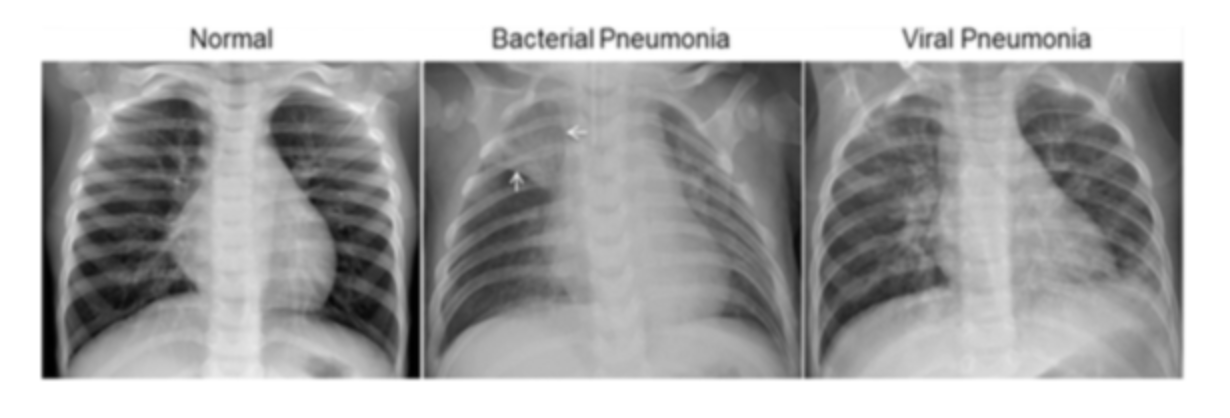
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

## Project Description

In this project, we will perform Pneumonia classification using chest X-ray images as
a binary classification task to determine whether an X-ray image indicates the presence or absence
of pneumonia. To make this task more robust, we will implement Deep Autoencoders as part
of an unsupervised feature learning approach which is the main focus of this project. The goal is that the
encoder part of the autoencoder compresses the input X-ray images into a lower-dimensional
latent space. The decoder part of the autoencoder reconstructs the input images from the
compressed representations. Then, we will do unsupervised Pre-training to train the autoencoder
to minimize the reconstruction loss, encouraging the model to learn valuable features in an
unsupervised manner. So, we will use the training set of X-ray images to train the autoencoder.
The encoder part of the trained autoencoder will serve as a feature extractor for the classification
task.


After that, we implement Convolutional
Neural Network (CNN), Variational Autoencoders (VAEs), and also VGG, ResNet, DenseNet.





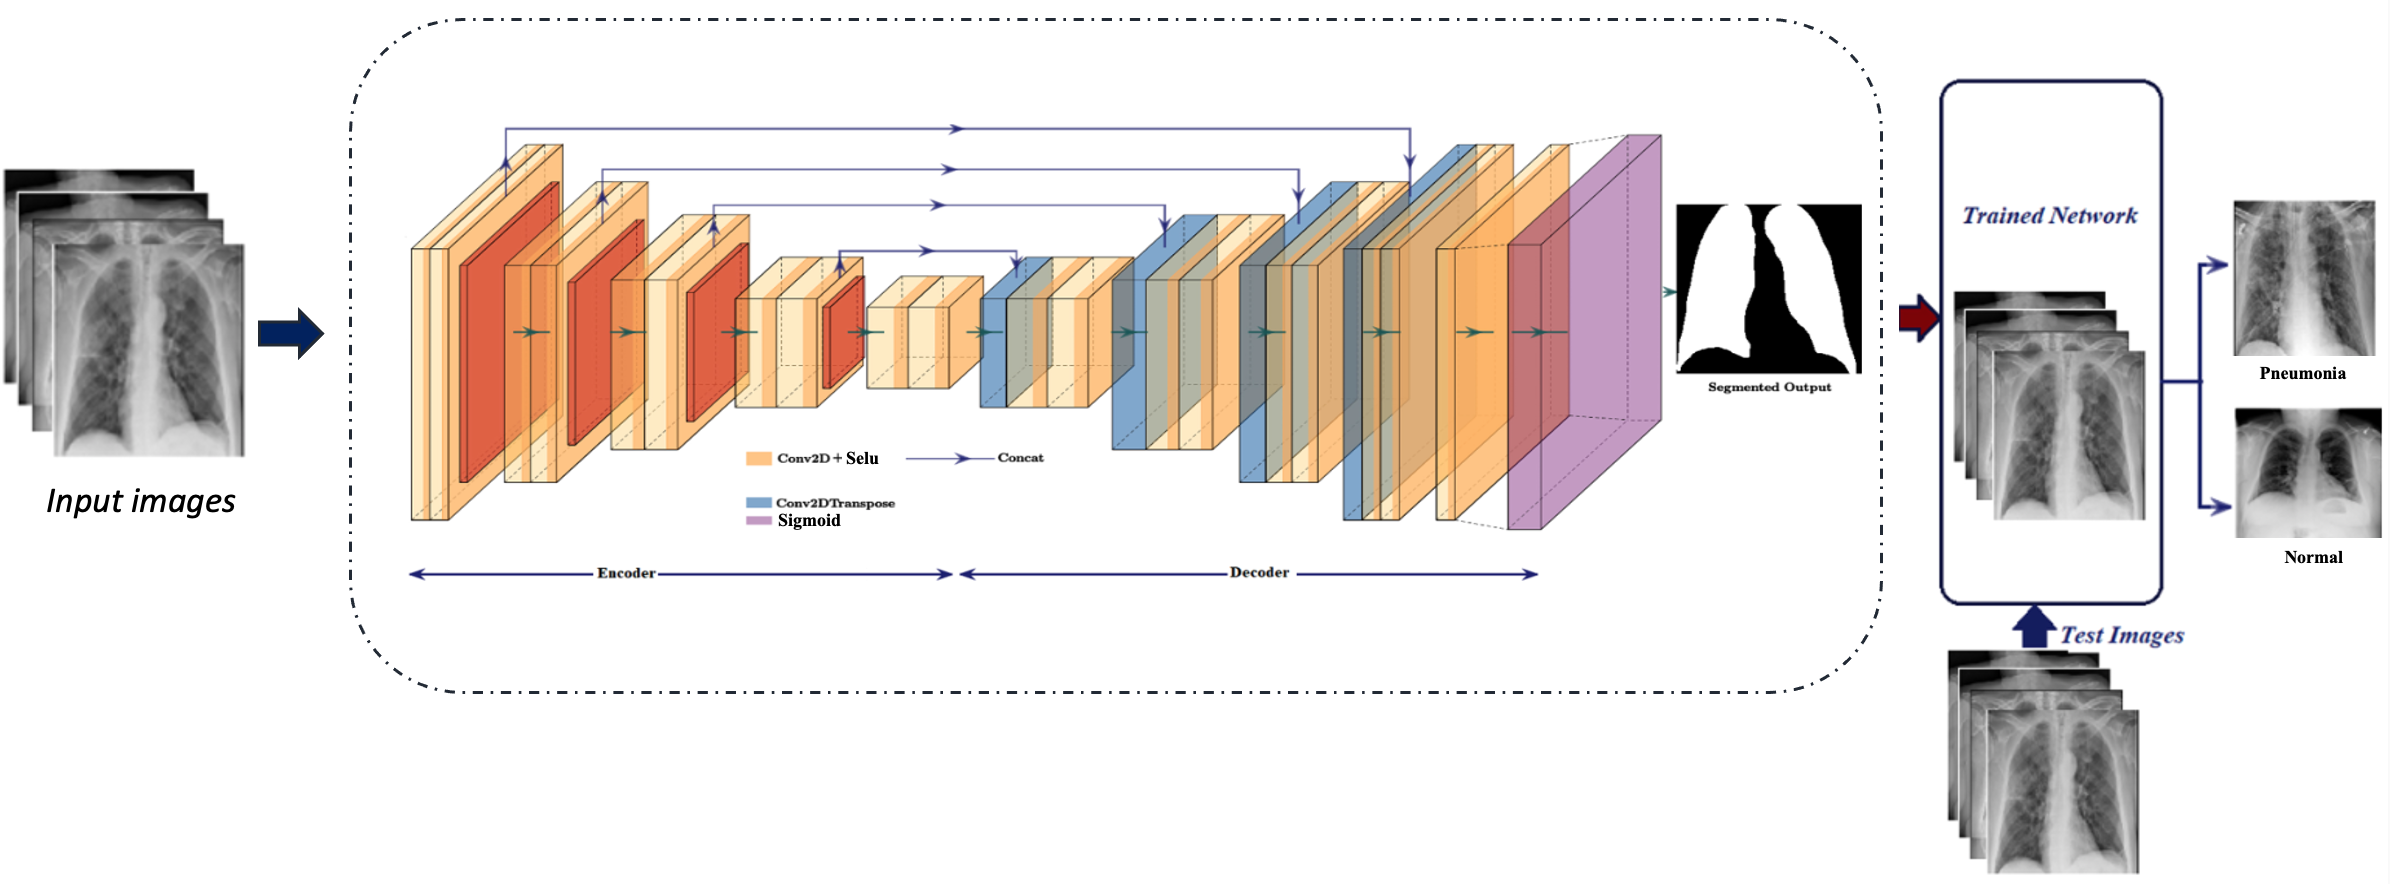

## Initial Setup

In [1]:
# Google Colab and File Handling
import os
import gc # Memory Management

# Data/Image Handling and Manipulation
import pandas as pd
import numpy as np
import random
import glob
import copy
import json
import cv2
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Colab-specific Display Utilities
from google.colab.patches import cv2_imshow

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torch.optim import Adam, SGD, NAdam
from torchvision import models
from torchvision.models import EfficientNet
from torchsummary import summary
import torch.optim as optim

# Data Splitting and Sampling
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_score, recall_score, precision_recall_fscore_support
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# Execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [ ]:
def download_content(url):
  FOLDER_NAME_ZIP="data.zip"
  FOLDER_NAME="data"
  URL=url

  # Get .ZIP file
  !wget --quiet -O $FOLDER_NAME_ZIP "$URL" \
  && echo -e "Files downloaded successfully!      File: $FOLDER_NAME_ZIP"

  # Unzip folder
  !unzip -q -o -d $FOLDER_NAME $FOLDER_NAME_ZIP \
  && echo -e "Files extracted successfully!       Folder:$FOLDER_NAME"

  # Remove .ZIP file
  !rm -f $FOLDER_NAME_ZIP \
  && echo -e "File: $FOLDER_NAME_ZIP removed successfully!\n"

In [ ]:
URL="https://drive.google.com/uc?export=download&id=106jW7G1VkRvZEosTJCHQcdrhPtJQVyZA&confirm=t"
download_content(URL)

Files downloaded successfully!      File: data.zip
Files extracted successfully!       Folder:data
File: data.zip removed successfully!



In [ ]:
# Set the working directory
wdir = '/content/data/chest_xray'
os.chdir(wdir)

## Data Exploration

In [ ]:
# Initialize lists to store data
data = {'RootFolder': [], 'Class': [], 'ImageName': []}

# Iterate through each root folder (train, val, test)
for root_folder in ['train', 'val', 'test']:
    root_path = os.path.join(wdir, root_folder)

    # Iterate through each class folder (normal, pneumonia)
    for class_folder in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(root_path, class_folder)

        # Iterate through each image in the class folder
        for img_name in os.listdir(class_path):
            data['RootFolder'].append(root_folder)
            data['Class'].append(class_folder)
            data['ImageName'].append(img_name)

# Create a DataFrame
df = pd.DataFrame(data)

In [ ]:
# Display the DataFrame
df.head()

RootFolder   Class                  ImageName
0      train  NORMAL          IM-0457-0001.jpeg
1      train  NORMAL  NORMAL2-IM-0775-0001.jpeg
2      train  NORMAL          IM-0437-0001.jpeg
3      train  NORMAL  NORMAL2-IM-0682-0001.jpeg
4      train  NORMAL  NORMAL2-IM-0852-0001.jpeg

In [ ]:
df.describe()

RootFolder      Class          ImageName
count        5856       5856               5856
unique          3          2               5856
top         train  PNEUMONIA  IM-0457-0001.jpeg
freq         5216       4273                  1

In [ ]:
# Create a new DataFrame with class and number_of_instances
df_instances = pd.DataFrame(df['Class'].value_counts().reset_index())
df_instances.columns = ['anomaly_class', 'number_of_instances']

# Display the new DataFrame
df_instances

anomaly_class  number_of_instances
0     PNEUMONIA                 4273
1        NORMAL                 1583

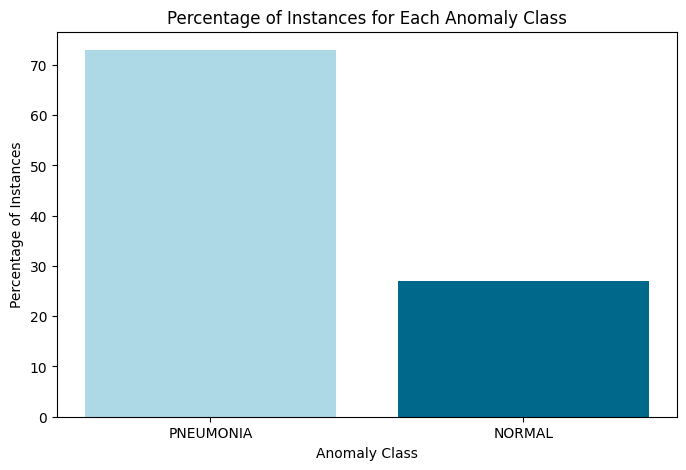

In [ ]:
# Calculate percentages
df_instances['percentage'] = (df_instances['number_of_instances'] / df_instances['number_of_instances'].sum()) * 100

light_blue = '#ADD8E6'
darker_blue = '#00688B'

# Bar chart with percentages
plt.figure(figsize=(8, 5))
bars = plt.bar(df_instances['anomaly_class'], df_instances['percentage'], color=[light_blue, darker_blue])
plt.title('Percentage of Instances for Each Anomaly Class')
plt.xlabel('Anomaly Class')
plt.ylabel('Percentage of Instances')

plt.show()


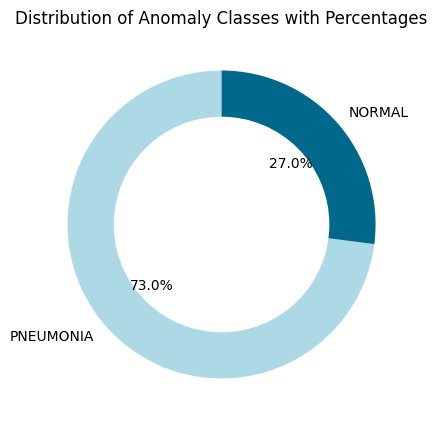

In [ ]:
# Donut chart with percentages
plt.figure(figsize=(8, 5))
plt.pie(df_instances['percentage'], labels=df_instances['anomaly_class'], autopct='%1.1f%%', colors=[light_blue, darker_blue], startangle=90)
plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))
plt.title('Distribution of Anomaly Classes with Percentages')
plt.show()

<ipython-input-15-5bfa824520bb>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(target_size, resample=Image.ANTIALIAS)


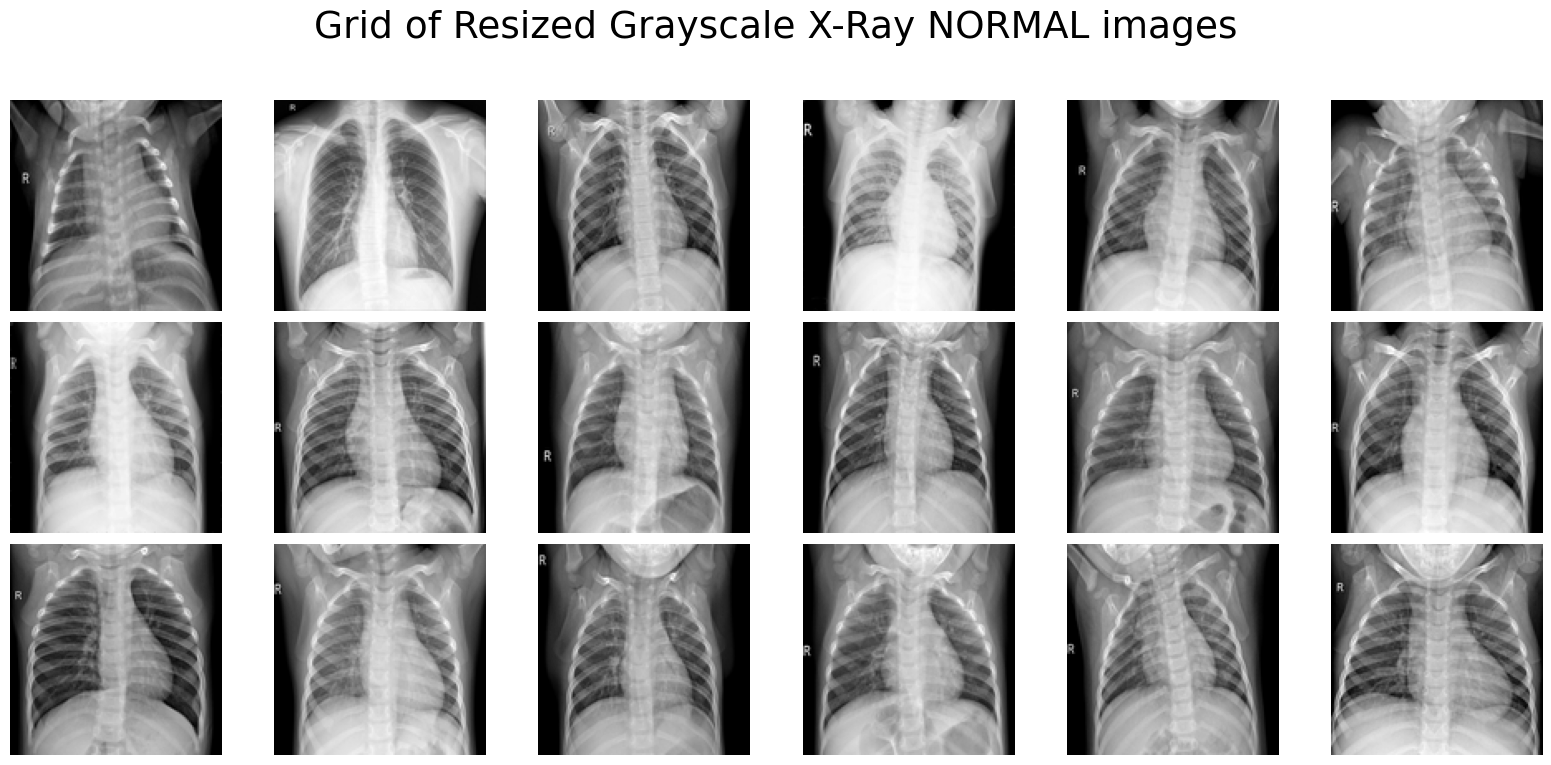

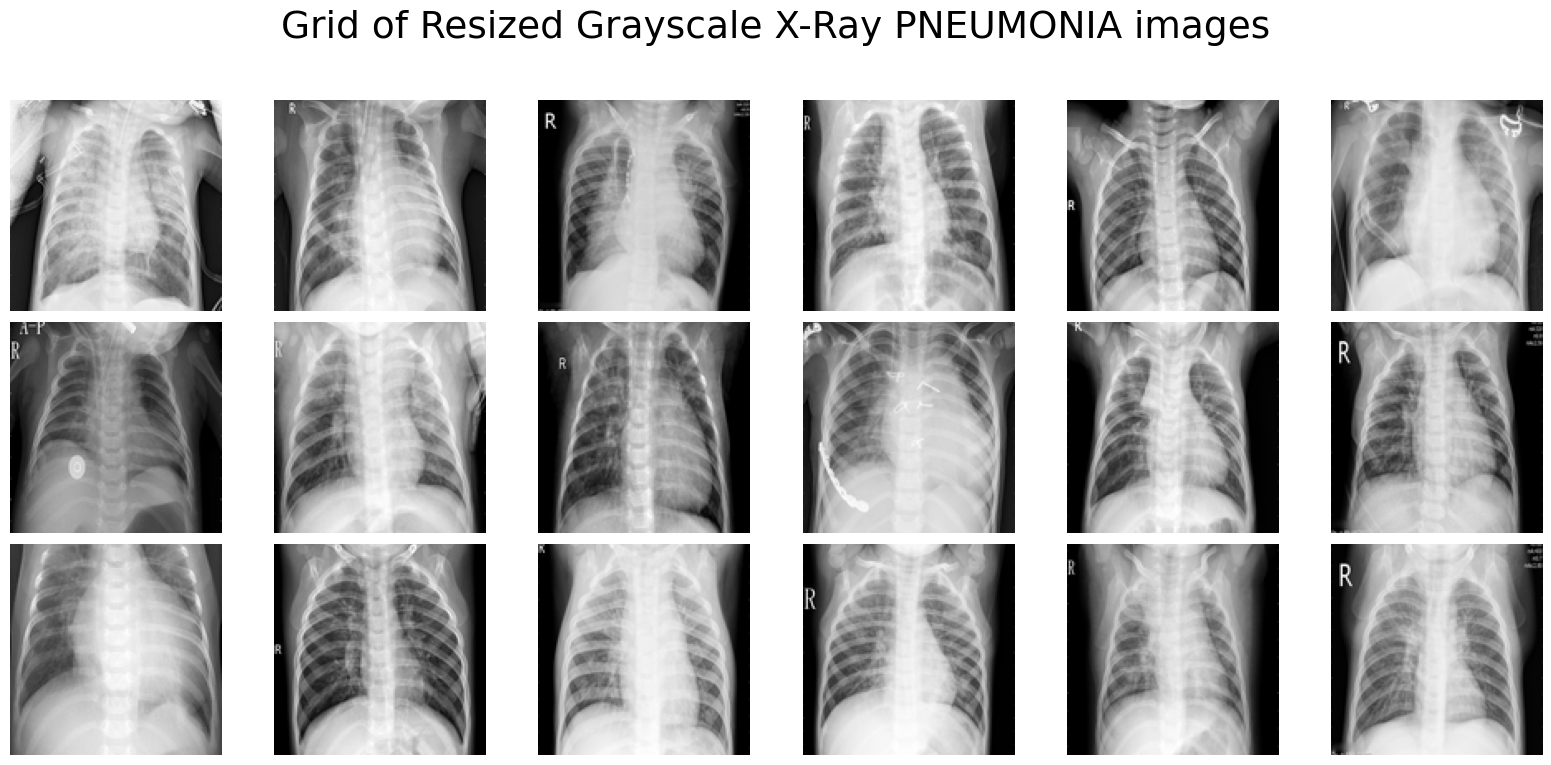

In [ ]:
# Function to load and display resized images in  grid
def display_resized_images_in_grid(image_folder, class_label, num_images=5, nrows=4, ncols=5, target_size=(128, 128)):
    image_paths = os.listdir(os.path.join(wdir, 'train', class_label))
    random.shuffle(image_paths)
    image_paths = image_paths[:num_images]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
    fig.suptitle(f'Grid of Resized Grayscale X-Ray {class_label} images', fontsize=27)

    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img_path = os.path.join(wdir, 'train', class_label, image_paths[i])
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_resized = img.resize(target_size, resample=Image.ANTIALIAS)

            ax.imshow(img_resized, cmap=cm.gray)  # Display in grayscale
            ax.axis('off')

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

# Display 20 resized grayscale images from 'NORMAL' class in  grid
display_resized_images_in_grid('train', 'NORMAL', num_images=20, nrows=3, ncols=6, target_size=(128, 128))

# Display 20 resized grayscale images from 'PNEUMONIA' class in  grid
display_resized_images_in_grid('train', 'PNEUMONIA', num_images=20, nrows=3, ncols=6, target_size=(128, 128))

plt.show()


## Data Balancing

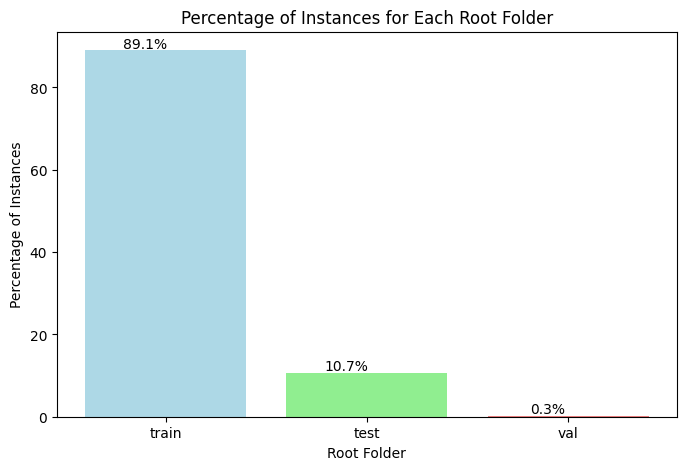

In [ ]:
# Count the number of instances for each root folder
df_instances = df['RootFolder'].value_counts().reset_index()
df_instances.columns = ['RootFolder', 'Number of Instances']

# Calculate percentages
df_instances['Percentage'] = (df_instances['Number of Instances'] / df_instances['Number of Instances'].sum()) * 100

# Bar chart with percentages
plt.figure(figsize=(8, 5))
bars = plt.bar(df_instances['RootFolder'], df_instances['Percentage'], color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Percentage of Instances for Each Root Folder')
plt.xlabel('Root Folder')
plt.ylabel('Percentage of Instances')

# Display percentages on top of the bars
for bar, percentage in zip(bars, df_instances['Percentage']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', color='black')

plt.show()


In [ ]:
# Count the number of instances for each root folder and class
df_instances = df.groupby(['RootFolder', 'Class']).size().unstack(fill_value=0).reset_index()

# Calculate the total number of instances for each root folder
df_instances['TotalInstances'] = df_instances['NORMAL'] + df_instances['PNEUMONIA']

# Print the number and percentage of instances for 'NORMAL' and 'PNEUMONIA' for each root folder
for index, row in df_instances.iterrows():
    root_folder = row['RootFolder']
    normal_instances = row['NORMAL']
    pneumonia_instances = row['PNEUMONIA']
    total_instances = row['TotalInstances']

    print(f"For {root_folder}:")
    print(f"  - Normal instances: {normal_instances} ({(normal_instances / total_instances) * 100:.2f}%)")
    print(f"  - Pneumonia instances: {pneumonia_instances} ({(pneumonia_instances / total_instances) * 100:.2f}%)")
    print(f"  - Total instances: {total_instances}")
    print()

For test:
  - Normal instances: 234 (37.50%)
  - Pneumonia instances: 390 (62.50%)
  - Total instances: 624

For train:
  - Normal instances: 1341 (25.71%)
  - Pneumonia instances: 3875 (74.29%)
  - Total instances: 5216

For val:
  - Normal instances: 8 (50.00%)
  - Pneumonia instances: 8 (50.00%)
  - Total instances: 16



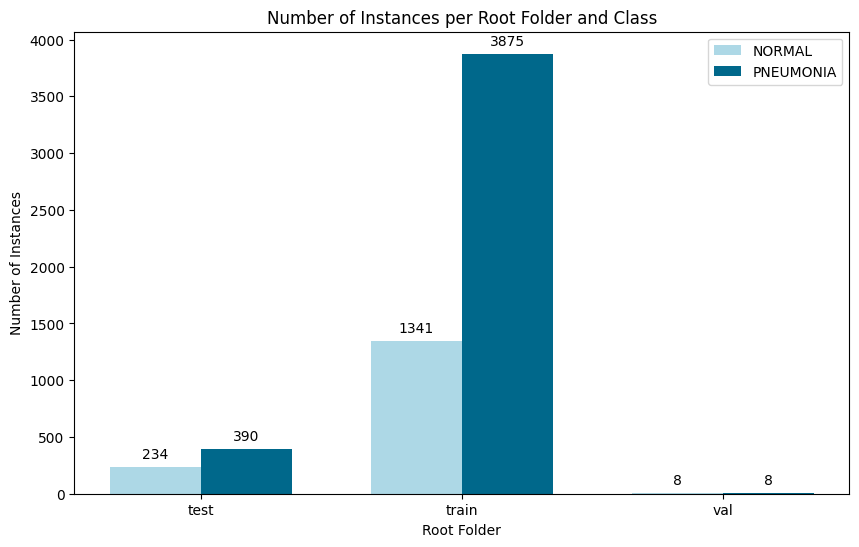

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Grouped bar chart
bar_width = 0.35
index = np.arange(len(df_instances['RootFolder']))

bar1 = plt.bar(index, df_instances['NORMAL'], bar_width, label='NORMAL', color=light_blue)
bar2 = plt.bar(index + bar_width, df_instances['PNEUMONIA'], bar_width, label='PNEUMONIA', color=darker_blue)

# Set labels and title
plt.xlabel('Root Folder')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Root Folder and Class')
plt.xticks(index + bar_width / 2, df_instances['RootFolder'])
plt.legend()

# Display the values on top of the bars
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, round(yval), ha='center', va='bottom')

# Show the plot
plt.show()


## Modeling

In [ ]:
! pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=df4a6ebf47ebdf2a00168092ab338c88fe8afa40615a0d43097abfef075655c5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


### Data Transformation


- Transform to tensor: Converts the PIL Image to a PyTorch tensor.
- Resize: Resizes the input image to a fixed size of 256 pixels in both height and width. This ensures that all input images have the same size.
- Normalization: Normalizes the tensor by subtracting the mean values and dividing by the standard deviation for each channel. Normalization helps stabilize the training process and ensures that input values are within a reasonable range.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

###Data Loader

In [ ]:
train_dir = '/content/data/chest_xray/train'
test_dir = '/content/data/chest_xray/test'

IMG_SIZE = (256, 256, 3)
BATCH_SIZE = 32

Since tha Validation set is very small, a new sample was created taking 10% of the training data.

In [ ]:
def custom_loader(path):
    with Image.open(path) as img:
        return img.convert("RGB")

# Load the custom dataset
dataset = ImageFolder(root=train_dir, transform=transform, loader=custom_loader)

# Get the labels and indices of the dataset
labels = [label for _, label in dataset]
indices = list(range(len(dataset)))

# Use StratifiedShuffleSplit to split the dataset into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in sss.split(indices, labels):
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    val_dataset = torch.utils.data.Subset(dataset, val_index)

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
test_dataset = ImageFolder(root=test_dir, transform=transform, loader=custom_loader)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

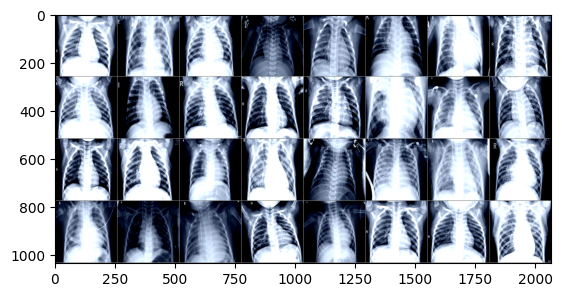

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize'
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class_names = dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [ ]:
labels

tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1])

In [ ]:
# get some random training images
val_dataiter = iter(val_loader)
val_images, val_labels = next(val_dataiter)

In [ ]:
val_labels

tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 4694
Validation size: 522
Test size: 624


In [ ]:
# Print the number of batches in each DataLoader
print(f"Number of batches in trainloader: {len(train_loader)}")
print(f"Number of batches in valloader: {len(val_loader)}")
print(f"Number of batches in testloader: {len(test_loader)}")

Number of batches in trainloader: 147
Number of batches in valloader: 17
Number of batches in testloader: 20


### Encoder Decoder

In [ ]:
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder (EfficientNet-B4)
        self.encoder = torchvision.models.efficientnet_b4()
        self.encoder._fc = nn.Identity()  # Remove the fully connected layers
        self.encoder._avg_pooling = nn.Identity()
        self.encoder._dropout = nn.Identity()

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1792 * 8 * 8, 128 * 16 * 2 * 2),  # Projection to match 2x2x128*16 output shape
            nn.Unflatten(1, (128 * 16, 2, 2)),  # Reshape to 128*16 channels, 2x2
            nn.ConvTranspose2d(128 * 16, 128 * 8, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (4x4x128*8)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(128 * 8, 128 * 4, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (8x8x128*4)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(128 * 4, 128 * 2, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (16x16x128*2)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(128 * 2, 128, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (32x32x128)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (64x64x64)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (128x128x32)
            nn.SELU(),  # SELU activation
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # ConvTranspose2d Layer (256x256x3)
            nn.Sigmoid()  # Sigmoid activation to scale output between 0 and 1
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Reshape encoder output to match the input size for the decoder
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.pad(x, (0, 1792 * 8 * 8 - x.size(1)))  # Pad to match required size

        # Decoder
        reconstruction = self.decoder(x)
        return reconstruction

# Instantiate the model
model = AutoEncoder()

# Move the model to the same device as the input data (CPU or GPU)
model.to(device)

# Print model summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]           1,296
       BatchNorm2d-2         [-1, 48, 128, 128]              96
              SiLU-3         [-1, 48, 128, 128]               0
            Conv2d-4         [-1, 48, 128, 128]             432
       BatchNorm2d-5         [-1, 48, 128, 128]              96
              SiLU-6         [-1, 48, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 128, 128]               0
           Conv2d-13         [-1, 24, 128, 128]           1,152
      BatchNorm2d-14         [-1, 24, 1

In [ ]:
sample_input = torch.randn(1, 3, 256, 256).to(device)  # Moving the tensor to GPU if available

# Pass the input through the encoder
encoder_output = model.encoder(sample_input)

# Check the shape of the encoder output
print("Encoder output shape:", encoder_output.shape)

Encoder output shape: torch.Size([1, 1000])


#### Prepare the model Training

Loss function based on Cross-Entropy loss and Adam Optimizer.

Adam is an optimization algorithm that adapts the learning rates of individual parameters. It combines ideas from RMSprop and Momentum. The Adam optimizer maintains an adaptive learning rate for each parameter and adjusts it based on the past gradients.

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The following training loop serves as an autoencoder. The model is trained to encode the input data into a lower-dimensional representation (encoder) and then decode it back to the original input (decoder). The goal is to minimize the reconstruction loss, which measures the difference between the original input and the reconstructed output.

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, _ = data
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Reconstruction loss
            loss.backward()
            optimizer.step()

            # Accumulate loss for the epoch
            running_loss += loss.item()

        # Print statistics for the epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {average_loss:.4f}")

    print('Finished Training')

In [ ]:
num_epochs=10

train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10] Loss: 0.2988
Epoch [2/10] Loss: 0.2764
Epoch [3/10] Loss: 0.2746
Epoch [4/10] Loss: 0.2751
Epoch [5/10] Loss: 0.2735
Epoch [6/10] Loss: 0.2720
Epoch [7/10] Loss: 0.2718
Epoch [8/10] Loss: 0.2693
Epoch [9/10] Loss: 0.2676
Epoch [10/10] Loss: 0.2684
Finished Training


#### Extract features using the trained autoencoder

In [ ]:
# Initialize the autoencoder
autoencoder = model
autoencoder.eval()  # Set in evaluation mode
autoencoder.to(device)

# Extract features using the autoencoder
encoded_features = []
true_labels = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to(device)

        # Get encoded representation (from the penultimate layer of the encoder)
        encoded_output = autoencoder.encoder(inputs)
        encoded_features.append(encoded_output.view(encoded_output.size(0), -1).cpu().numpy())
        true_labels.append(labels.numpy())

# Convert extracted features and labels to NumPy arrays
encoded_features = torch.tensor(np.concatenate(encoded_features, axis=0), dtype=torch.float32)
true_labels = torch.tensor(np.concatenate(true_labels, axis=0), dtype=torch.float32)

####Binary classifier using the encoded features

In [ ]:
# Define a binary classifier using the encoded features
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Define datasets and data loaders for binary classification
binary_dataset = TensorDataset(encoded_features, true_labels)
batch_size = 32
binary_loader = DataLoader(binary_dataset, batch_size=batch_size, shuffle=True)

# Initialize the binary classifier
input_size = encoded_features.shape[1]
binary_classifier = BinaryClassifier(input_size)
binary_classifier.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(binary_classifier.parameters(), lr=0.001)

In [ ]:
def train_binary_classifier(binary_classifier, binary_loader, criterion, optimizer, num_epochs):
    binary_classifier.to(device)
    binary_classifier.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for inputs, labels in binary_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = binary_classifier(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Convert logits to binary predictions (0 or 1)
            predictions = torch.round(torch.sigmoid(outputs))
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.detach().cpu().numpy())  # Use detach() here

        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)

        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(binary_loader):.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

In [ ]:
train_binary_classifier(binary_classifier, binary_loader, criterion, optimizer, num_epochs)

Epoch [1/10] Loss: 0.4455, Accuracy: 0.8208, Precision: 0.8821, Recall: 0.8758, F1: 0.8790
Epoch [2/10] Loss: 0.3782, Accuracy: 0.8500, Precision: 0.8963, Recall: 0.9025, F1: 0.8994
Epoch [3/10] Loss: 0.3698, Accuracy: 0.8549, Precision: 0.8954, Recall: 0.9111, F1: 0.9032
Epoch [4/10] Loss: 0.3528, Accuracy: 0.8545, Precision: 0.8914, Recall: 0.9157, F1: 0.9034
Epoch [5/10] Loss: 0.3452, Accuracy: 0.8585, Precision: 0.8928, Recall: 0.9200, F1: 0.9062
Epoch [6/10] Loss: 0.3444, Accuracy: 0.8609, Precision: 0.8956, Recall: 0.9200, F1: 0.9076
Epoch [7/10] Loss: 0.3383, Accuracy: 0.8611, Precision: 0.8939, Recall: 0.9226, F1: 0.9080
Epoch [8/10] Loss: 0.3376, Accuracy: 0.8605, Precision: 0.8953, Recall: 0.9197, F1: 0.9073
Epoch [9/10] Loss: 0.3358, Accuracy: 0.8630, Precision: 0.9003, Recall: 0.9171, F1: 0.9087
Epoch [10/10] Loss: 0.3327, Accuracy: 0.8598, Precision: 0.8939, Recall: 0.9206, F1: 0.9070


In [ ]:
def evaluate_binary_classifier(model, data_loader, criterion):
    model.eval()
    true_labels = []
    predicted_probs = []
    losses = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            losses.append(loss.item())  # Store the loss value

            predicted_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_labels = [1 if p > 0.5 else 0 for p in predicted_probs]

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    avg_loss = sum(losses) / len(losses)  # Calculate the average loss

    # Display the average loss
    print(f'Average Loss: {avg_loss:.4f}')

    return accuracy, precision, recall, f1


#### Evaluate on validation set


In [ ]:
# Extract features from validation set using the autoencoder
encoded_val_features = []
true_val_labels = []

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs = inputs.to(device)

        # Get encoded representation (from the penultimate layer of the encoder)
        encoded_output = autoencoder.encoder(inputs)
        encoded_val_features.append(encoded_output.view(encoded_output.size(0), -1).cpu().numpy())
        true_val_labels.append(labels.numpy())

# Convert extracted features and labels to NumPy arrays
encoded_val_features = torch.tensor(np.concatenate(encoded_val_features, axis=0), dtype=torch.float32)
true_val_labels = torch.tensor(np.concatenate(true_val_labels, axis=0), dtype=torch.float32)

# Define a dataset for the validation set with the extracted features
val_dataset_with_features = TensorDataset(encoded_val_features, true_val_labels)
val_loader_with_features = DataLoader(val_dataset_with_features, batch_size=batch_size)

In [ ]:
# Evaluation on validation set
val_accuracy, val_precision, val_recall, val_f1 = evaluate_binary_classifier(binary_classifier, val_loader_with_features,criterion)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

Average Loss: 0.3247
Validation Accuracy: 0.8716
Validation Precision: 0.9169
Validation Recall: 0.9098
Validation F1 Score: 0.9133


#### Evaluate on test set

In [ ]:
# Extract features from the test set using the autoencoder
encoded_test_features = []
true_test_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)

        # Get encoded representation (from the penultimate layer of the encoder)
        encoded_output = autoencoder.encoder(inputs)
        encoded_test_features.append(encoded_output.view(encoded_output.size(0), -1).cpu().numpy())
        true_test_labels.append(labels.numpy())

# Convert extracted features and labels to NumPy arrays
encoded_test_features = torch.tensor(np.concatenate(encoded_test_features, axis=0), dtype=torch.float32)
true_test_labels = torch.tensor(np.concatenate(true_test_labels, axis=0), dtype=torch.float32)

# Define a dataset for the test set with the extracted features
test_dataset_with_features = TensorDataset(encoded_test_features, true_test_labels)
test_loader_with_features = DataLoader(test_dataset_with_features, batch_size=batch_size)

In [ ]:
# Evaluation on test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_binary_classifier(binary_classifier, test_loader_with_features,criterion)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Average Loss: 0.4562
Test Accuracy: 0.8173
Test Precision: 0.8053
Test Recall: 0.9333
Test F1 Score: 0.8646


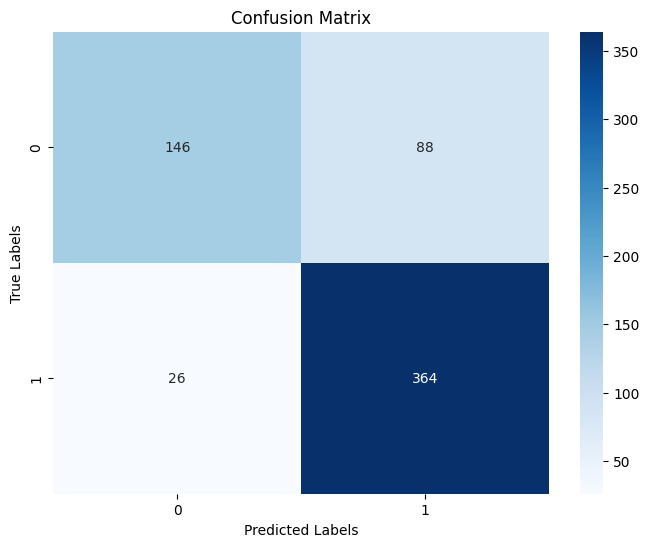

In [ ]:
# Calculate predictions and true labels
all_labels = []
all_predictions = []

for inputs, labels in test_loader_with_features:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = binary_classifier(inputs)
    predictions = torch.round(torch.sigmoid(outputs))

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predictions.detach().cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

###Variational Autoencoder

Variational Autoencoder is a type of generative model that combines ideas from traditional autoencoders and probabilistic modeling. VAEs were introduced as a way to learn a probabilistic mapping from observed data to a latent space.

VAEs incorporate probabilistic modeling into the autoencoder framework using variational inference. Variational inference is a technique for approximating complex probability distributions. It aims to find an approximation to an intractable posterior distribution.

In a VAE, the latent space is treated as a probability distribution rather than a fixed vector as in traditional autoencoders.
The encoder produces not only the mean but also the variance of a distribution (usually a multivariate Gaussian) in the latent space for each input sample.
Sampling is performed in the latent space using the reparameterization trick, which allows for backpropagation through the sampling process.
Objective Function:

The VAE objective function consists of two parts: the reconstruction loss and the regularization term (KL divergence). The reconstruction loss measures how well the decoder reconstructs the input. The KL divergence regularizes the latent space, encouraging it to follow a simple distribution (usually a standard Gaussian).

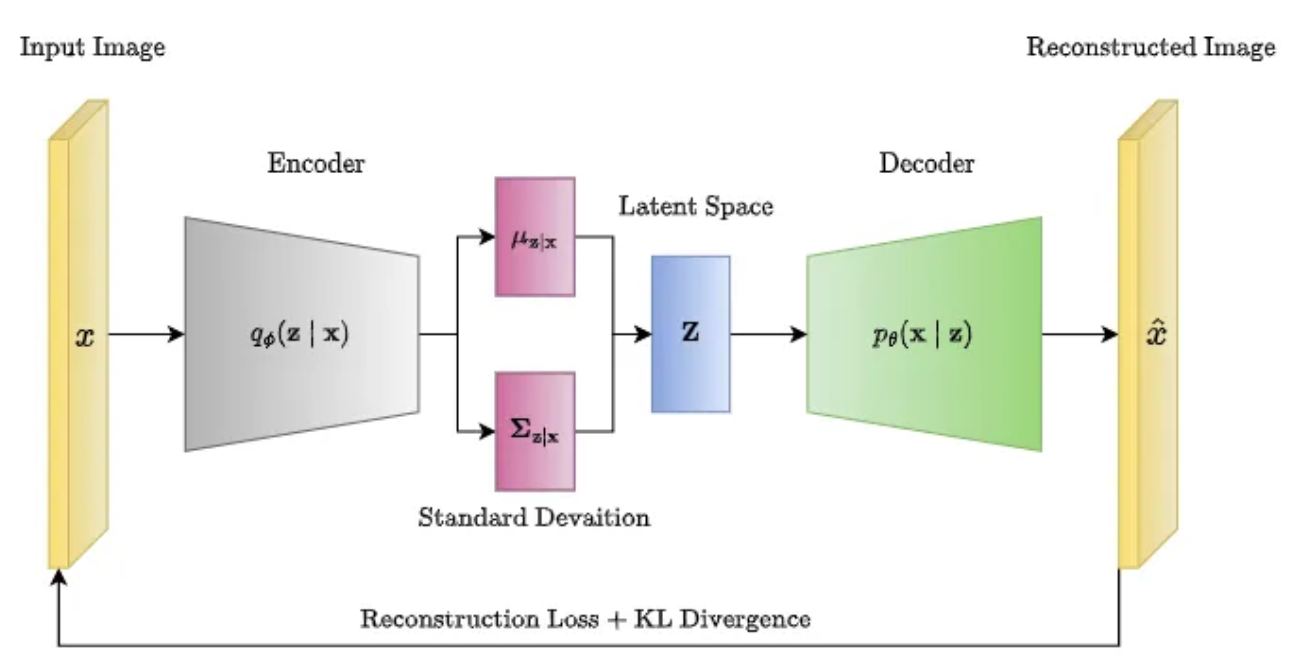

In [ ]:
train_dataset = ImageFolder(root=train_dir, transform=transform, loader=custom_loader)

# Define the total dataset size
dataset_size = len(train_dataset)
indices = list(range(dataset_size))

# Split the dataset into train and validation sets with stratified sampling
train_indices, val_indices = train_test_split(indices, test_size=0.1, stratify=train_dataset.targets)

# Define samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders for train and validation sets
vae_train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
vae_val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoEncoder, self).__init__()
        # Encoder (EfficientNet-B4)
        #self.encoder = EfficientNet.from_pretrained('efficientnet-b4')
        self.encoder = torchvision.models.efficientnet_b4()
        self.encoder._fc = nn.Identity()  # Remove the fully connected layers
        self.encoder._avg_pooling = nn.Identity()
        self.encoder._dropout = nn.Identity()

        # Define mean and log-variance layers for the latent space
        self.fc_mean = nn.Linear(1000, latent_size)
        self.fc_logvar = nn.Linear(1000, latent_size)

        # Decoder
        self.decoder = nn.Sequential(
          nn.Linear(latent_size, 1792),  # Projection to match encoded size
          nn.ReLU(),
          nn.Linear(1792, 512),  # Projection to reduce dimensions
          nn.ReLU(),
          nn.Linear(512, 3 * 256 * 256),  # Output layer matching the target image size
          nn.Sigmoid()  # Sigmoid activation to scale output between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the encoder output

        # Obtain mean and log-variance from encoder output
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)

        # Reparameterization trick to sample from the latent space
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_hat = self.decoder(z)
        return x_hat.view(-1, 3, 256, 256), mu, logvar  # Reshape the output to the desired image size


In [ ]:
# Define the latent size
latent_size = 32

# Instantiate the VAE with the specified latent size
vae_model = VariationalAutoEncoder(latent_size)

# Move the model to the same device as the input data (CPU or GPU)
vae_model.to(device)

# Print model summary
summary(vae_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]           1,296
       BatchNorm2d-2         [-1, 48, 128, 128]              96
              SiLU-3         [-1, 48, 128, 128]               0
            Conv2d-4         [-1, 48, 128, 128]             432
       BatchNorm2d-5         [-1, 48, 128, 128]              96
              SiLU-6         [-1, 48, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 128, 128]               0
           Conv2d-13         [-1, 24, 128, 128]           1,152
      BatchNorm2d-14         [-1, 24, 1

In [ ]:
# Function to calculate the loss
def vae_loss(recon_x, x, mu, std):
    # Reconstruction loss (MSE or other suitable loss)
    criterion = nn.MSELoss()
    reconstruction_loss = criterion(recon_x, x)

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2, dim=1)
    kl_divergence = torch.mean(kl_divergence)

    return reconstruction_loss + kl_divergence

#### Prepare the model Training

In [ ]:
num_epochs = 10

In [ ]:
vae = VariationalAutoEncoder(latent_size).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    vae.train()
    running_loss = 0.0

    for i, data in enumerate(vae_train_loader):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        recon_batch, mu, std = vae(inputs)
        loss = vae_loss(recon_batch, inputs, mu, std)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch-level information after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(vae_train_loader):.4f}")

print('Finished Training the VAE')

Epoch [1/10] Loss: 52.6817
Epoch [2/10] Loss: 33.8252
Epoch [3/10] Loss: 41.7267
Epoch [4/10] Loss: 20.4010
Epoch [5/10] Loss: 11.5794
Epoch [6/10] Loss: 81.9506
Epoch [7/10] Loss: 36.6160
Epoch [8/10] Loss: 19.5524
Epoch [9/10] Loss: 26.2016
Epoch [10/10] Loss: 37.4424
Finished Training the VAE


#### Extract features from the VAE

In [ ]:
# Function to extract features from the VAE
def extract_vae_features(model, data_loader, device='cuda'):
    model.eval()
    encoded_features = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)

            # Get encoded representation
            _, encoded_output, _ = model(inputs)
            encoded_features.append(encoded_output.cpu().numpy())
            true_labels.append(labels.numpy())

    encoded_features = torch.tensor(np.concatenate(encoded_features, axis=0), dtype=torch.float32)
    true_labels = torch.tensor(np.concatenate(true_labels, axis=0), dtype=torch.float32)

    return encoded_features, true_labels


In [ ]:
encoded_train_features, train_true_labels = extract_vae_features(vae, vae_train_loader)

#### Binary classifier using the encoded features

In [ ]:
# Define a binary classifier using the encoded features
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the autoencoder
autoencoder = vae_model
autoencoder.eval()  # Set in evaluation mode
autoencoder.to(device)

VariationalAutoEncoder(
  (encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

In [ ]:
batch_size = 32

# Initialize the binary classifier
input_size = encoded_train_features.shape[1]
binary_classifier = BinaryClassifier(input_size)
binary_classifier.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(binary_classifier.parameters(), lr=0.001)

In [ ]:
test_dataset = ImageFolder(root=test_dir, transform=transform, loader=custom_loader)
vae_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Extract features from the validation set using the trained VAE
encoded_val_features, val_true_labels = extract_vae_features(vae, vae_val_loader)

# Extract features from the test set using the trained VAE
encoded_test_features, test_true_labels = extract_vae_features(vae, vae_test_loader)

In [ ]:
# Define datasets and data loaders for binary classification
train_dataset = TensorDataset(encoded_train_features, train_true_labels)
val_dataset = TensorDataset(encoded_val_features, val_true_labels)
test_dataset = TensorDataset(encoded_test_features, test_true_labels)

batch_size = 32
vae_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
vae_val_loader = DataLoader(val_dataset, batch_size=batch_size)
vae_test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define loss function and optimizer for the binary classifier
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(binary_classifier.parameters(), lr=0.001)

In [ ]:
for epoch in range(num_epochs):
    binary_classifier.train()  # Set the model to train mode
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for inputs, labels in vae_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = binary_classifier(inputs)
        loss = criterion(outputs.squeeze(), labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store labels and predictions for evaluation
        predicted_probs = torch.sigmoid(outputs).detach().cpu().numpy()
        predicted_labels = [1 if p > 0.5 else 0 for p in predicted_probs]
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_labels)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(vae_train_loader)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # Print epoch-wise metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

print('Finished Training')

Epoch [1/10] Loss: 0.5750, Accuracy: 0.7318, Precision: 0.7433, Recall: 0.9759, F1: 0.8439
Epoch [2/10] Loss: 0.5494, Accuracy: 0.7429, Precision: 0.7429, Recall: 1.0000, F1: 0.8525
Epoch [3/10] Loss: 0.5366, Accuracy: 0.7429, Precision: 0.7429, Recall: 1.0000, F1: 0.8525
Epoch [4/10] Loss: 0.5180, Accuracy: 0.7429, Precision: 0.7429, Recall: 1.0000, F1: 0.8525
Epoch [5/10] Loss: 0.5075, Accuracy: 0.7429, Precision: 0.7429, Recall: 1.0000, F1: 0.8525
Epoch [6/10] Loss: 0.5007, Accuracy: 0.7446, Precision: 0.7444, Recall: 0.9991, F1: 0.8532
Epoch [7/10] Loss: 0.4936, Accuracy: 0.7531, Precision: 0.7575, Recall: 0.9819, F1: 0.8553
Epoch [8/10] Loss: 0.4902, Accuracy: 0.7612, Precision: 0.7705, Recall: 0.9664, F1: 0.8574
Epoch [9/10] Loss: 0.4862, Accuracy: 0.7682, Precision: 0.7820, Recall: 0.9538, F1: 0.8594
Epoch [10/10] Loss: 0.4835, Accuracy: 0.7695, Precision: 0.7919, Recall: 0.9355, F1: 0.8577
Finished Training


In [ ]:
encoded_train_features.shape

torch.Size([4694, 32])

In [ ]:
# Function to evaluate the binary classifier
def evaluate_binary_classifier(model, data_loader):
    model.eval()
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted_probs.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predicted_labels = [1 if p > 0.5 else 0 for p in predicted_probs]

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

In [ ]:
def evaluate_binary_classifier(model, test_loader,criterion):
    model.eval()

    all_labels = []
    all_predictions = []
    epoch_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs))

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            # Calculate loss
            loss = criterion(outputs.squeeze(), labels.float())
            epoch_loss += loss.item()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # Calculate average loss
    avg_loss = epoch_loss / len(test_loader)

    print(f'Average Loss: {avg_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Evaluate on validation set

Average Loss: 0.4806
Accuracy: 0.7989
Precision: 0.8377
Recall: 0.9046
F1 Score: 0.8699


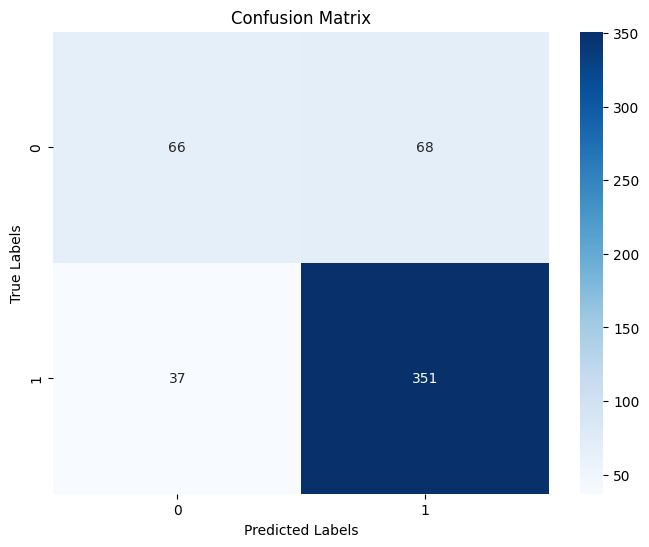

In [ ]:
evaluate_binary_classifier(binary_classifier, vae_val_loader, criterion)

#### Evaluate on test set


Average Loss: 0.7136
Accuracy: 0.6522
Precision: 0.6648
Recall: 0.8949
F1 Score: 0.7628


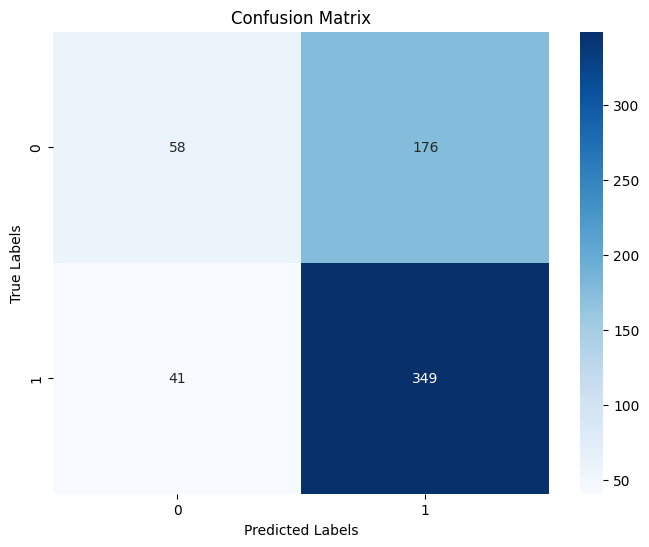

In [ ]:
# Evaluate on the test set
evaluate_binary_classifier(binary_classifier, vae_test_loader, criterion)

### Convolutional Neural Network (CNN)

Convolutional Neural Networks (CNNs) are specialized artificial neural networks designed for processing and interpreting visual data. Inspired by the human visual system, CNNs are designed to work with image data and can capture local patterns more efficiently than fully connected layers. They can also handle larger input images, leading to better performance.

We will create a custom CNN architecture with multiple convolutional layers, then max-pooling layers, and finally, a fully connected layer for classification. We will also use the image size 256x256, as CNNs can handle larger images better.

#### Data Checks (global checks)

In [ ]:
print("Train Dataset:", len(train_dataset))
print("Validation Dataset:", len(val_dataset))
print("Test Dataset:", len(test_dataset))
print("\nTrain Loader:", len(train_loader))
print("Validation Loader:", len(val_loader))
print("Test Loader:", len(test_loader))

Train Dataset: 5216
Validation Dataset: 522
Test Dataset: 624

Train Loader: 147
Validation Loader: 17
Test Loader: 20


In [ ]:
# Checking the images from the test dataset
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print('Shape of the Image: ',example_data.shape)
print('Shape of the label: ', example_targets.shape)
print(example_targets[0:6])

Shape of the Image:  torch.Size([32, 3, 256, 256])
Shape of the label:  torch.Size([32])
tensor([1, 1, 1, 1, 0, 1])


In [ ]:
# Shape of data, using the Dataset
sample = test_dataset[0]
img = sample[0]
label = sample[1]
print('Shape of the Image:', img.shape) # 1 image and its label
print('Label:', label)

Shape of the Image: torch.Size([3, 256, 256])
Label: 0


In [ ]:
# Check Batch size
train_batch_size = train_loader.batch_size
test_batch_size = test_loader.batch_size
val_batch_size = val_loader.batch_size

print(f"Train: {train_batch_size}")
print(f"Test: {test_batch_size}")
print(f"Val: {val_batch_size}")

Train: 32
Test: 32
Val: 32


#### Model Architecture: **ConvNets**

ConvNet architectures explicitly assume that the inputs are images, allowing us to encode specific properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

Specialized in tasks like image recognition, ConvNets utilize convolutional layers to extract hierarchical features from input images automatically. Their success in computer vision has made ConvNets a fundamental tool in various applications, enabling efficient and accurate pattern recognition in diverse visual datasets.

Below is a visualization of how they work:

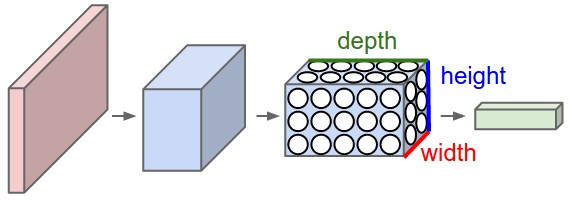

**Fig. 1:** ConvNet arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers. Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations.
In this example, the red input layer holds the image, so its width and height would be the image's dimensions, and the depth would be 3, representing the channels (Red, Green, and Blue channels).

Therefore as previous mentioned, we will **create a custom CNN architecture with multiple convolutional layers, followed by max-pooling layers, and finally a fully connected layer for classification. We will also use the image size of 256x256, as CNNs can handle larger images better.**

The implementation of this architecture and her details can be seen below.

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    # Convolutional layers
    self.conv2 = nn.Sequential(
      # First convolutional layer: input channels = 3 (RGB), output channels = 64, kernel size = 3x3, stride = 1, padding = 1
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1,padding = 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      # Second convolutional layer: input channels = 64, output channels = 128, kernel size = 4x4, stride = 2, padding = 1
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4,stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

      # Third convolutional layer: input channels = 128, output channels = 256, kernel size = 4x4, stride = 2, padding = 1
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,stride=2, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

      # Fourth convolutional layer: input channels = 256, output channels = 512, kernel size = 4x4, stride = 2, padding = 1
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4,stride=2, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

      # Fifth convolutional layer: input channels = 512, output channels = 512, kernel size = 4x4, stride = 2, padding = 1
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4,stride=2, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

      # Sixth convolutional layer: input channels = 512, output channels = 512, kernel size = 4x4, stride = 2, padding = 1
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4,stride=2, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
    )

    # Fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(512*8*8, 256),  # Adjust input size based on the output size of the last convolutional layer
        nn.Linear(256, 128),
        nn.Linear(128, 64),
        nn.Linear(64, 2)  # Assuming a binary classification task (2 output classes)
    )


  def forward(self,x):
    # Forward pass through convolutional layers
    out = self.conv2(x)
    # Flatten the output to pass through fully connected layers
    out = out.view(out.size(0), -1)
    # Forward pass through fully connected layers
    out = self.fc(out)
    return out

Print model details and summary:

In [ ]:
# Checking the desired output with random input
model = ConvNet()
x = torch.rand(1, 3, 256, 256)
print(model(x).shape)
output = model(x)
print(output)

torch.Size([1, 2])
tensor([[0.0119, 0.0517]], grad_fn=<AddmmBackward0>)


In [ ]:
# Initializing the model
model = ConvNet().to(device)
# Print model
model

ConvNet(
  (conv2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, c

In [ ]:
summary(model, input_size=(3, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]           1,792
       BatchNorm2d-2         [32, 64, 256, 256]             128
              ReLU-3         [32, 64, 256, 256]               0
            Conv2d-4        [32, 128, 128, 128]         131,200
       BatchNorm2d-5        [32, 128, 128, 128]             256
              ReLU-6        [32, 128, 128, 128]               0
         MaxPool2d-7        [32, 128, 128, 128]               0
            Conv2d-8          [32, 256, 64, 64]         524,544
       BatchNorm2d-9          [32, 256, 64, 64]             512
             ReLU-10          [32, 256, 64, 64]               0
        MaxPool2d-11          [32, 256, 64, 64]               0
           Conv2d-12          [32, 512, 32, 32]       2,097,664
      BatchNorm2d-13          [32, 512, 32, 32]           1,024
             ReLU-14          [32, 512,

#### Hyperparameters

In [ ]:
# Setting the hyperparameters
LEARNING_RATE = 0.01 #0.001
NUM_CLASSES = 2
NUM_EPOCHS = 30
CHANNEL_IMG = 3
# feature_d = 64
PATIENCE = 5

MODEL_NAME = 'cnn'

#### Define loss equations and entropy

The **loss function**, defined as *CrossEntropyLoss()*, is very iften used for classification problems, measuring the discrepancy between predicted and actual class labels.
**The optimizer**, created using *torch.optim.Adam*, is configured to update the model's parameters during training, with a specified learning rate.

The **combination of both functions set the foundation for training the model**, guiding its updates to improve its performance on the given classification task

In [ ]:
# Define the loss function for classification tasks
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer with specified parameters
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

#### Functions to execute/train the model

The below two functions encapsulate the training and evaluation of a neural network, provide a concise and flexible framework for training and assessing neural network models.

*   **epoch_iter** function to handle the iteration over data batches, computes metrics, and performing backpropagation for training.
*   **train_model** function that executes the training process, saving the best model based on validation loss and implementing early stopping to prevent overfitting.


In [ ]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
  if is_train:
    assert optimizer is not None, "When training, please provide an optimizer."

  num_batches = len(dataloader)

  if is_train:
    model.train() # put model in train mode
  else:
    model.eval()

  total_loss = 0.0
  preds = []
  labels = []

  with torch.set_grad_enabled(is_train):
    for batch, (X, y) in enumerate(tqdm(dataloader)):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      if is_train:
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # Save training metrics
      total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)
      preds.extend(final_pred.cpu().numpy())
      labels.extend(y.cpu().numpy())

  #Accuracy
  accuracy = accuracy_score(labels, preds)

  # Precision, recall, F1
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=1.0)

  # Confusion Matrix
  conf_matrix = confusion_matrix(labels, preds)

  # return total_loss / num_batches, accuracy, precision, recall, f1, conf_matrix
  return {
      'loss': total_loss / num_batches,
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'conf_matrix': conf_matrix
  }

In [ ]:
# Train model with early stopping
def train_model(num_epochs, train_loader, val_loader, model, model_name, loss_fn, optimizer, patience):
  latest_model_name = f'latest_model_{model_name}.pth'
  best_model_name = f'best_model_{model_name}.pth'

  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  no_improvement_count = 0

  print("Start training...")

  for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_metrics = epoch_iter(train_loader, model, loss_fn, optimizer)
    val_metrics = epoch_iter(val_loader, model, loss_fn, is_train=False)

    # Save model when val loss improves
    if val_metrics['loss'] < best_val_loss:
      best_val_loss = val_metrics['loss']
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
      torch.save(save_dict, best_model_name)
      no_improvement_count = 0  # Reset the counter
    else:
      no_improvement_count += 1

    # Save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
    torch.save(save_dict, latest_model_name)

    # Save training history for plotting purposes
    train_history["loss"].append(train_metrics['loss'])
    train_history["accuracy"].append(train_metrics['accuracy'])

    val_history["loss"].append(val_metrics['loss'])
    val_history["accuracy"].append(val_metrics['accuracy'])

    print(f"> Train loss: {train_metrics['loss']:.3f} \t Train acc: {train_metrics['accuracy']:.3f} \t Val loss: {val_metrics['loss']:.3f} \t Val acc: {val_metrics['accuracy']:.3f}")

    # Early stopping check
    if no_improvement_count >= patience:
      print(f'\n\nEarly stopping after {epoch + 1} epochs without improvement.')
      break

  print("\nFinished")

  return train_history, val_history

#### Train ConvNet Model

Training process for the model:

In [ ]:
train_history, val_history = train_model(NUM_EPOCHS, train_loader, val_loader, model, MODEL_NAME, loss_fn, optimizer, PATIENCE)

Start training...

Epoch 1/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 8.677 	 Train acc: 0.831 	 Val loss: 0.149 	 Val acc: 0.939

Epoch 2/30


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


> Train loss: 0.181 	 Train acc: 0.929 	 Val loss: 0.110 	 Val acc: 0.956

Epoch 3/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.140 	 Train acc: 0.944 	 Val loss: 0.107 	 Val acc: 0.958

Epoch 4/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.113 	 Train acc: 0.958 	 Val loss: 0.112 	 Val acc: 0.960

Epoch 5/30


100%|██████████| 17/17 [00:08<00:00,  2.02it/s]


> Train loss: 0.098 	 Train acc: 0.963 	 Val loss: 0.091 	 Val acc: 0.966

Epoch 6/30


100%|██████████| 17/17 [00:08<00:00,  2.02it/s]


> Train loss: 0.088 	 Train acc: 0.967 	 Val loss: 0.097 	 Val acc: 0.973

Epoch 7/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.090 	 Train acc: 0.965 	 Val loss: 0.092 	 Val acc: 0.969

Epoch 8/30


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


> Train loss: 0.076 	 Train acc: 0.971 	 Val loss: 0.097 	 Val acc: 0.967

Epoch 9/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.065 	 Train acc: 0.975 	 Val loss: 0.106 	 Val acc: 0.966

Epoch 10/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.074 	 Train acc: 0.973 	 Val loss: 0.073 	 Val acc: 0.983

Epoch 11/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.060 	 Train acc: 0.978 	 Val loss: 0.072 	 Val acc: 0.977

Epoch 12/30


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


> Train loss: 0.052 	 Train acc: 0.981 	 Val loss: 0.067 	 Val acc: 0.979

Epoch 13/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.049 	 Train acc: 0.982 	 Val loss: 0.076 	 Val acc: 0.979

Epoch 14/30


100%|██████████| 17/17 [00:08<00:00,  2.02it/s]


> Train loss: 0.064 	 Train acc: 0.980 	 Val loss: 0.087 	 Val acc: 0.985

Epoch 15/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.063 	 Train acc: 0.981 	 Val loss: 0.073 	 Val acc: 0.979

Epoch 16/30


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


> Train loss: 0.043 	 Train acc: 0.984 	 Val loss: 0.125 	 Val acc: 0.946

Epoch 17/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.042 	 Train acc: 0.984 	 Val loss: 0.084 	 Val acc: 0.973


Early stopping after 17 epochs without improvement.

Finished


#### Analyse training evolution

The function below, will display the training history for our model.

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(12,8))

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='validation')
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.xticks(np.arange(len(train_history['loss'])), np.arange(1, len(train_history['loss'])+1))
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='validation')
    plt.ylabel("Accuracy")
    plt.xlabel("Num. epochs")
    plt.xticks(np.arange(len(train_history['loss'])), np.arange(1, len(train_history['loss'])+1))
    plt.legend()

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

Display train and validation history of the model.

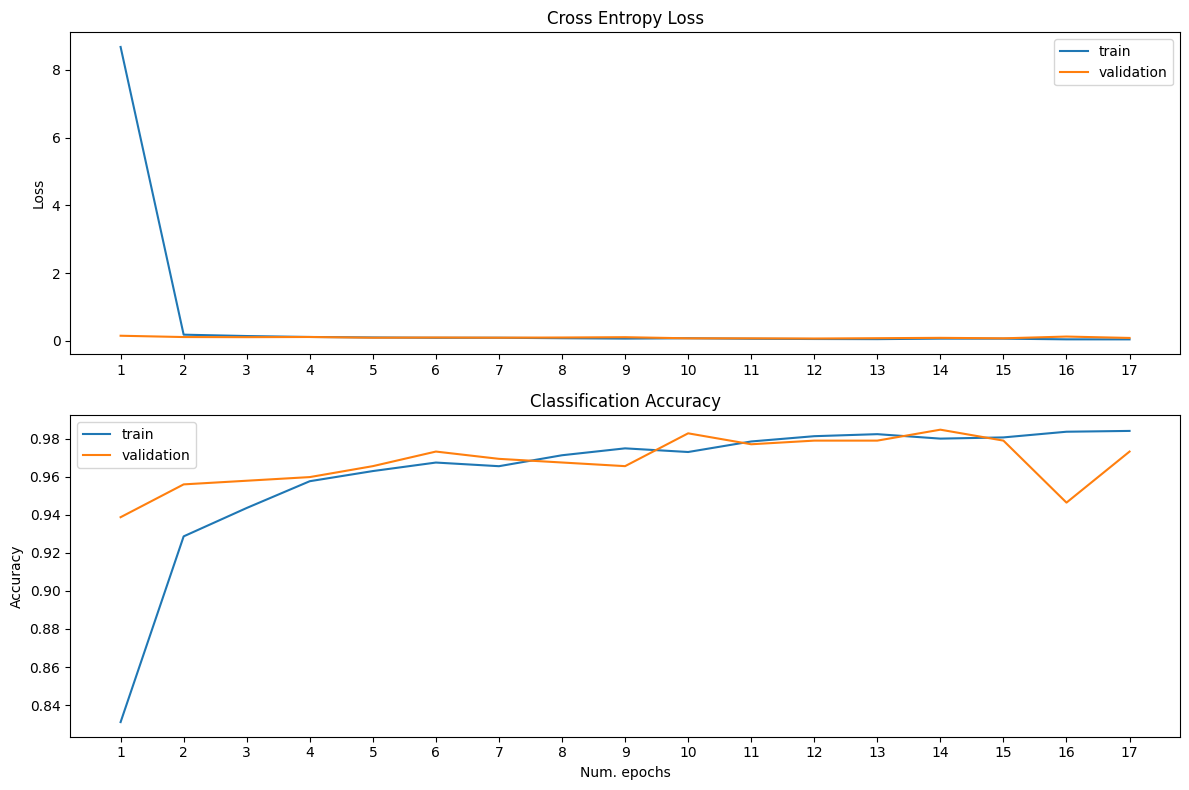

In [ ]:
plotTrainingHistory(train_history, val_history)

The results of our model are very positive and encouraging overall, as our model is performing reasonably after twelve epochs, reaching an early stop at epoch seventeen, as no improvement is shown.

We have an average **train accuracy of 98.1% with a validation accuracy of 97.9%**, which indicates that the model is learning from the training data and generalizing to new unseen data.

However, future work should monitor the model's performance over more epochs and possibly fine-tune hyperparameters or adjust the model architecture.


#### Model Evaluation (metrics)

In [ ]:
# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed
model = ConvNet().to(device)
checkpoint = torch.load('best_model_cnn.pth')
model.load_state_dict(checkpoint['model'])

test_metrics= epoch_iter(test_loader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_metrics['loss']:.3f} \nTest Accuracy: {test_metrics['accuracy']:.3f} "
      f"\nTest Precision: {test_metrics['precision']:.3f} \nTest Recall: {test_metrics['recall']:.3f} "
      f"\nTest F1: {test_metrics['f1']:.3f}" )


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Test Loss: 1.418 
Test Accuracy: 0.721 
Test Precision: 0.796 
Test Recall: 0.721 
Test F1: 0.667


The **test accuracy of 72,1%** is generally positive, indicating that the model performs well on the test set. The fact that the test accuracy **is lower than the validation accuracy can imply that the model is overfitting the training data**, meaning it has become too tailored to the training data and can struggle to generalize to new, unseen data.

It's essential to strike a balance between achieving high accuracy on the training data and ensuring the model's ability to generalize to new instances.

Regularization techniques or adjusting model complexity might be considered to address overfitting.

In [ ]:
# Generate a confusion matrix heatmap
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size for better readability
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

Next, and since the accuracy of our model refers to two individual classes, we created a **confusion matrix**. The goal is **to understand each class/label individual accuracy**.

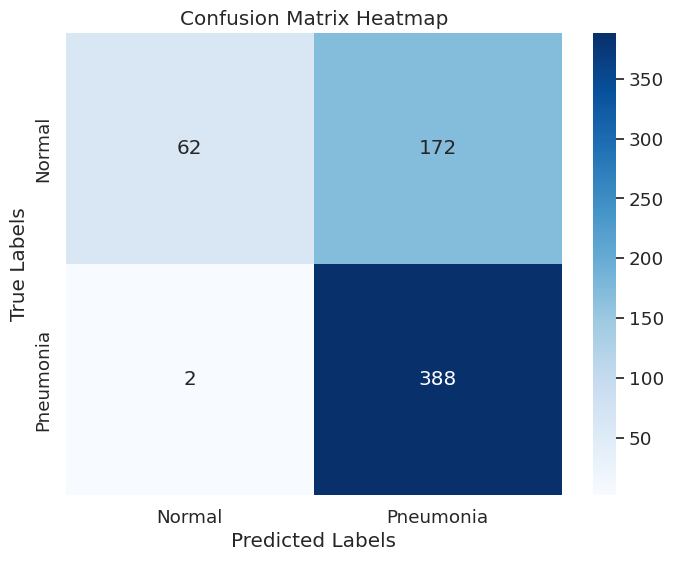

In [ ]:
# Plot the confusion matrix heatmap
class_names = [ "Normal", "Pneumonia"]
test_conf_matrix = test_metrics['conf_matrix']

plot_confusion_matrix(test_conf_matrix, class_names)

We can conclude from the confusion matrix that some images are, as expected, incorrectly labeled. Two "Pneumonia" labels were labeled as "Normal," and one hundred and seventy-two "Normal" labels were predicted as "Pneumonia.”

#### Show predicted and true labels

Function to do predictions on sampled images using the trained model.

In [ ]:
def showPredAndTrueLabels(model, dataloader, num_examples=20):
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= num_examples: break
      X, y = X.to(device), y.to(device)
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(5, 5, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(46, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

Display <font color="GREEN">true labels</font> and <font color="RED">predicted labels</font>.

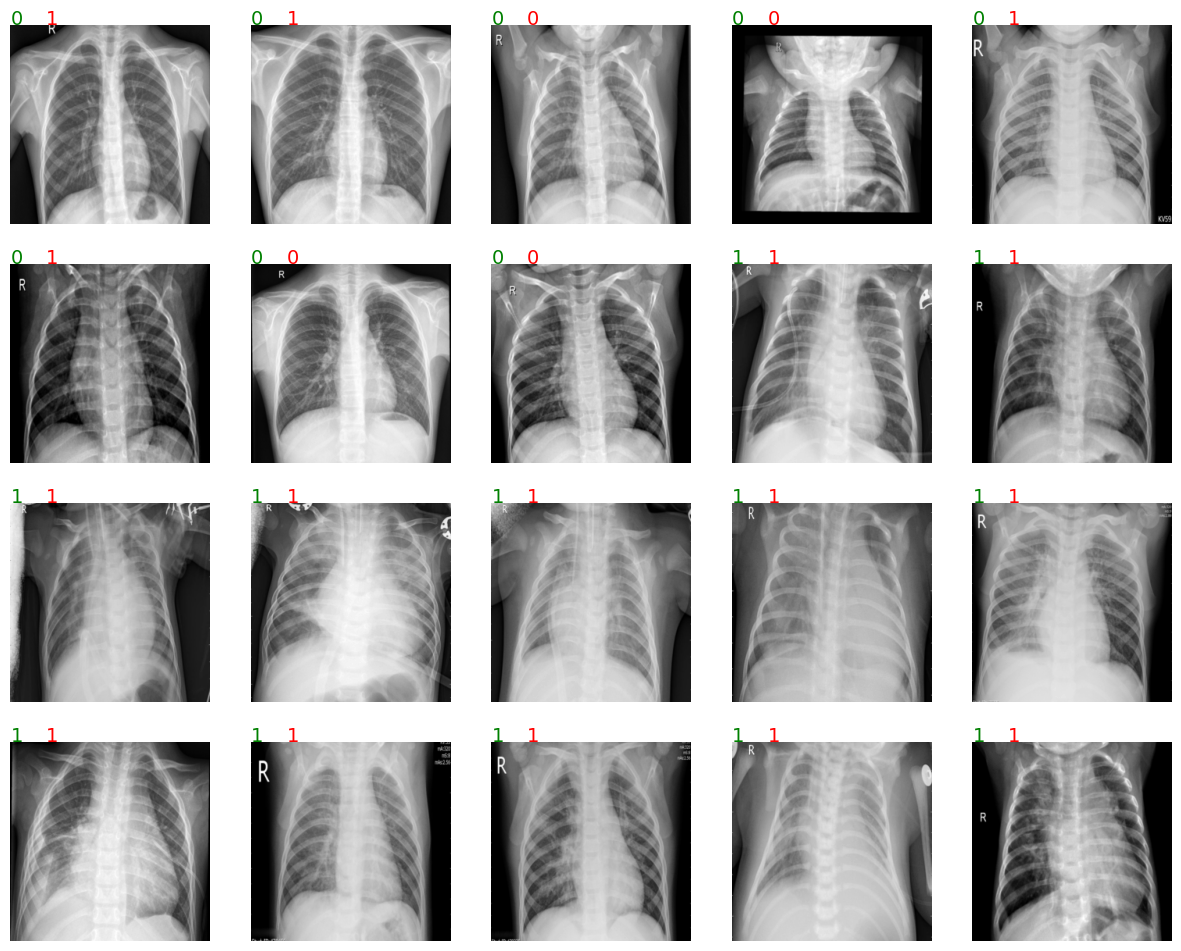

In [ ]:
showPredAndTrueLabels(model, test_loader)

### VGG16 (pre-trainned model)

VGG16 refers to the VGG model, also called VGGNet. It is a deep convolutional neural network (CNN) architecture known for its simplicity and effectiveness in image classification tasks.

**VGG16 consists of** 16 layers, including 13 convolutional layers and three fully connected layers, as shown in the image below. It gained popularity for its uniform architecture with small convolutional filters (3x3) and deep stacking, contributing to its success in various computer vision applications.

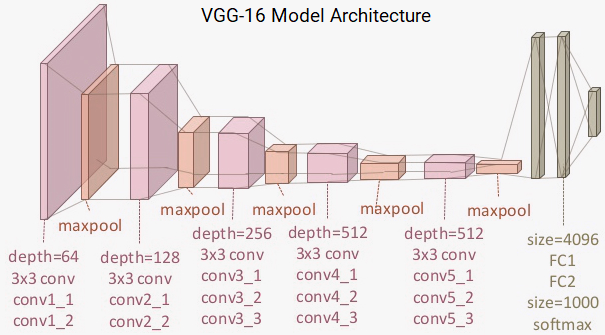





Pretrained models, such as VGG-16 and VGG-19, have already been trained on ImageNet, a collection of images from various categories. These models are created from the ground up and trained on millions of images across thousands of image categories using powerful GPUs.

Due to the large dataset used for training, the model has acquired a good representation of low-level features such as shapes, edges, rotation, lighting, and spatial information. These features can be shared to facilitate knowledge transfer and serve as a feature extractor for new images in various computer vision applications. Based on the concepts of transfer learning, the pre-trained model ought to be able to extract pertinent features from these new images, even if they belong to entirely different categories than those in the source dataset.

#### Load the pre-trained VGG16 model

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 2

In [ ]:
# Load the pre-trained VGG16 model
vgg16_pre = models.vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.7MB/s]


Print model details:

In [ ]:
# Freeze the parameters of the 'features' part
for param in vgg16_pre.features.parameters():
    param.required_grad = False

# Get the number of input features for the last fully connected layer (classifier[6])
num_features = vgg16_pre.classifier[6].in_features
features = list(vgg16_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, NUM_CLASSES)])

# Modify the 'classifier' part to get the correct number of output classes
vgg16_pre.classifier = nn.Sequential(*features)
print(vgg16_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Move the model to the specified device
vgg16_pre = vgg16_pre.to(device)

#### Hyperparameters

In [ ]:
# Setting the hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
STEP_SIZE = 10
GAMMA = 0.1

NUM_EPOCHS = 30
# CHANNEL_IMG = 3
PATIENCE = 5
MODEL_NAME = 'vgg16_pre'

#### Define loss equations and entropy, plus device and Learning Rate scheduler

**The loss function**, defined as *CrossEntropyLoss()*, is very iften used for classification problems, measuring the discrepancy between predicted and actual class labels. **The optimizer**, created using *torch.optim.Adam*, is configured to update the model's parameters during training, with a specified learning rate. **A learning rate** scheduler is implemented to dynamically adjust the learning rate during training, facilitating optimal convergence.

The **combination of both functions set the foundation for training and optimize the model**, guiding its updates to improve its performance on the given classification task

In [ ]:
# Define the loss function for classification tasks
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer with specified parameters
optimizer = optim.Adam(vgg16_pre.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Define a learning rate scheduler to decay the learning rate by a factor of 0.1 every 'step_size' epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

#### Model Summary

Print model summary:

In [ ]:
summary(vgg16_pre, input_size=(3, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]           1,792
              ReLU-2         [32, 64, 256, 256]               0
            Conv2d-3         [32, 64, 256, 256]          36,928
              ReLU-4         [32, 64, 256, 256]               0
         MaxPool2d-5         [32, 64, 128, 128]               0
            Conv2d-6        [32, 128, 128, 128]          73,856
              ReLU-7        [32, 128, 128, 128]               0
            Conv2d-8        [32, 128, 128, 128]         147,584
              ReLU-9        [32, 128, 128, 128]               0
        MaxPool2d-10          [32, 128, 64, 64]               0
           Conv2d-11          [32, 256, 64, 64]         295,168
             ReLU-12          [32, 256, 64, 64]               0
           Conv2d-13          [32, 256, 64, 64]         590,080
             ReLU-14          [32, 256,

#### Train the model

Training process for the model:

In [ ]:
train_history_vgg, val_history_vgg = train_model(NUM_EPOCHS, train_loader, val_loader, vgg16_pre, MODEL_NAME, loss_fn, optimizer, PATIENCE)

Start training...

Epoch 1/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 1.223 	 Train acc: 0.723 	 Val loss: 0.602 	 Val acc: 0.743

Epoch 2/30


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


> Train loss: 0.694 	 Train acc: 0.740 	 Val loss: 0.809 	 Val acc: 0.257

Epoch 3/30


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


> Train loss: 0.447 	 Train acc: 0.766 	 Val loss: 0.354 	 Val acc: 0.743

Epoch 4/30


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


> Train loss: 0.266 	 Train acc: 0.885 	 Val loss: 0.188 	 Val acc: 0.933

Epoch 5/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.234 	 Train acc: 0.916 	 Val loss: 0.407 	 Val acc: 0.837

Epoch 6/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.246 	 Train acc: 0.904 	 Val loss: 0.167 	 Val acc: 0.931

Epoch 7/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.164 	 Train acc: 0.944 	 Val loss: 0.133 	 Val acc: 0.946

Epoch 8/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.156 	 Train acc: 0.944 	 Val loss: 0.155 	 Val acc: 0.943

Epoch 9/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.168 	 Train acc: 0.941 	 Val loss: 0.135 	 Val acc: 0.950

Epoch 10/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.142 	 Train acc: 0.952 	 Val loss: 0.089 	 Val acc: 0.969

Epoch 11/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.143 	 Train acc: 0.951 	 Val loss: 0.161 	 Val acc: 0.946

Epoch 12/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.142 	 Train acc: 0.951 	 Val loss: 0.104 	 Val acc: 0.952

Epoch 13/30


100%|██████████| 17/17 [00:08<00:00,  1.98it/s]


> Train loss: 0.157 	 Train acc: 0.945 	 Val loss: 0.128 	 Val acc: 0.948

Epoch 14/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.129 	 Train acc: 0.956 	 Val loss: 0.105 	 Val acc: 0.966

Epoch 15/30


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


> Train loss: 0.161 	 Train acc: 0.950 	 Val loss: 0.244 	 Val acc: 0.927


Early stopping after 15 epochs without improvement.

Finished


#### Analyse training evolution

Display train and validation history of the model.

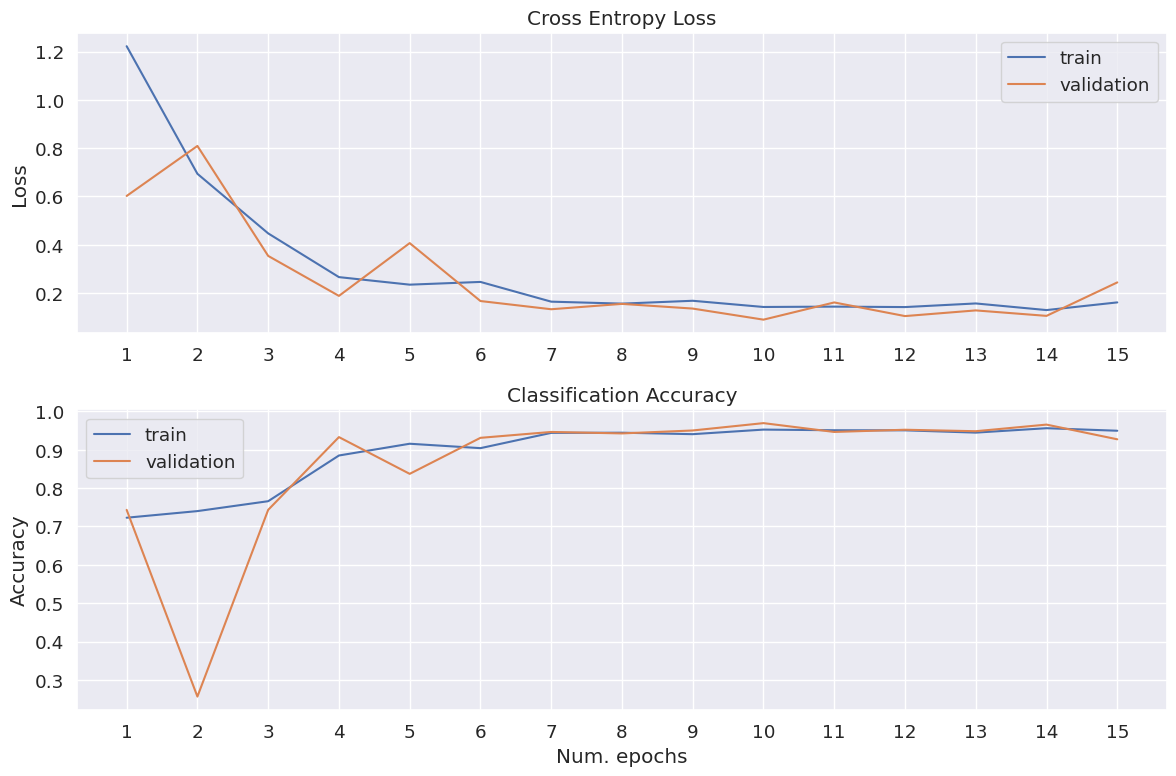

In [ ]:
plotTrainingHistory(train_history_vgg, val_history_vgg)

The results of our model are very positive and encouraging overall, as our model is performing reasonably after ten epochs, reaching an early stop at epoch fifteen, as no improvement is shown.

We have an average **train accuracy of 95.2% with a validation accuracy of 96.9%**, which indicates that the model is learning from the training data and generalizing to new unseen data.

However, future work should monitor the model's performance over more epochs and possibly fine-tune hyperparameters or adjust the model architecture.

#### Model Evalution (metrics)

In [ ]:
# Load the best model checkpoint
checkpoint = torch.load('best_model_vgg16_pre.pth')
vgg16_pre.load_state_dict(checkpoint['model'])

# Move the model to the specified device
vgg16_pre = vgg16_pre.to(device)

# Set the model to evaluation mode
vgg16_pre.eval()

# Assuming you have defined the test_loader and loss_fn
test_metrics = epoch_iter(test_loader, vgg16_pre, loss_fn, is_train=False)

print(f"\nTest Loss: {test_metrics['loss']:.3f} \nTest Accuracy: {test_metrics['accuracy']:.3f} "
      f"\nTest Precision: {test_metrics['precision']:.3f} \nTest Recall: {test_metrics['recall']:.3f} "
      f"\nTest F1: {test_metrics['f1']:.3f}" )

100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Test Loss: 0.836 
Test Accuracy: 0.729 
Test Precision: 0.788 
Test Recall: 0.729 
Test F1: 0.682


The **test accuracy of 72.9%** is generally positive, indicating that the model performs well on the test set. The fact that the test accuracy **is lower than the validation accuracy can imply that the model is overfitting the training data**, meaning it has become too tailored to the training data and can struggle to generalize to new, unseen data.

It's essential to balance achieving high accuracy on the training data and ensuring the model's ability to generalize to new instances.

Regularization techniques or adjusting model complexity might be considered to address overfitting.

Next, and since the accuracy of our model refers to two individual classes, we created a **confusion matrix**. The goal is **to understand each class/label individual accuracy**.

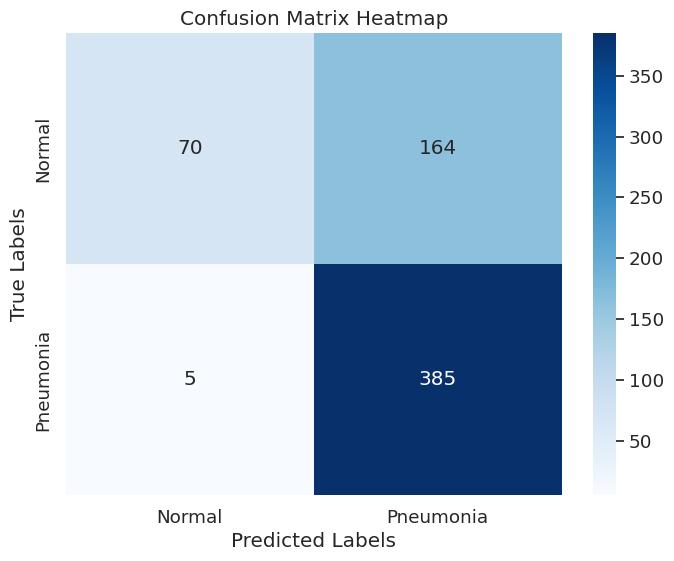

In [ ]:
# Plot the confusion matrix heatmap
class_names = ["Normal", "Pneumonia"]
test_conf_matrix = test_metrics['conf_matrix']

plot_confusion_matrix(test_conf_matrix, class_names)

We can see from the confusion matrix that some images are, as predicted, incorrectly labeled.

We can conclude from the confusion matrix that some images are, as expected, incorrectly labeled. Five "Pneumonia" labels were predicted as "Normal," and One hundred sixty-four "Normal" labels were predicted as "Pneumonia.”

#### Show predicted and true labels

Display <font color="GREEN">true labels</font> and <font color="RED">predicted labels</font>.

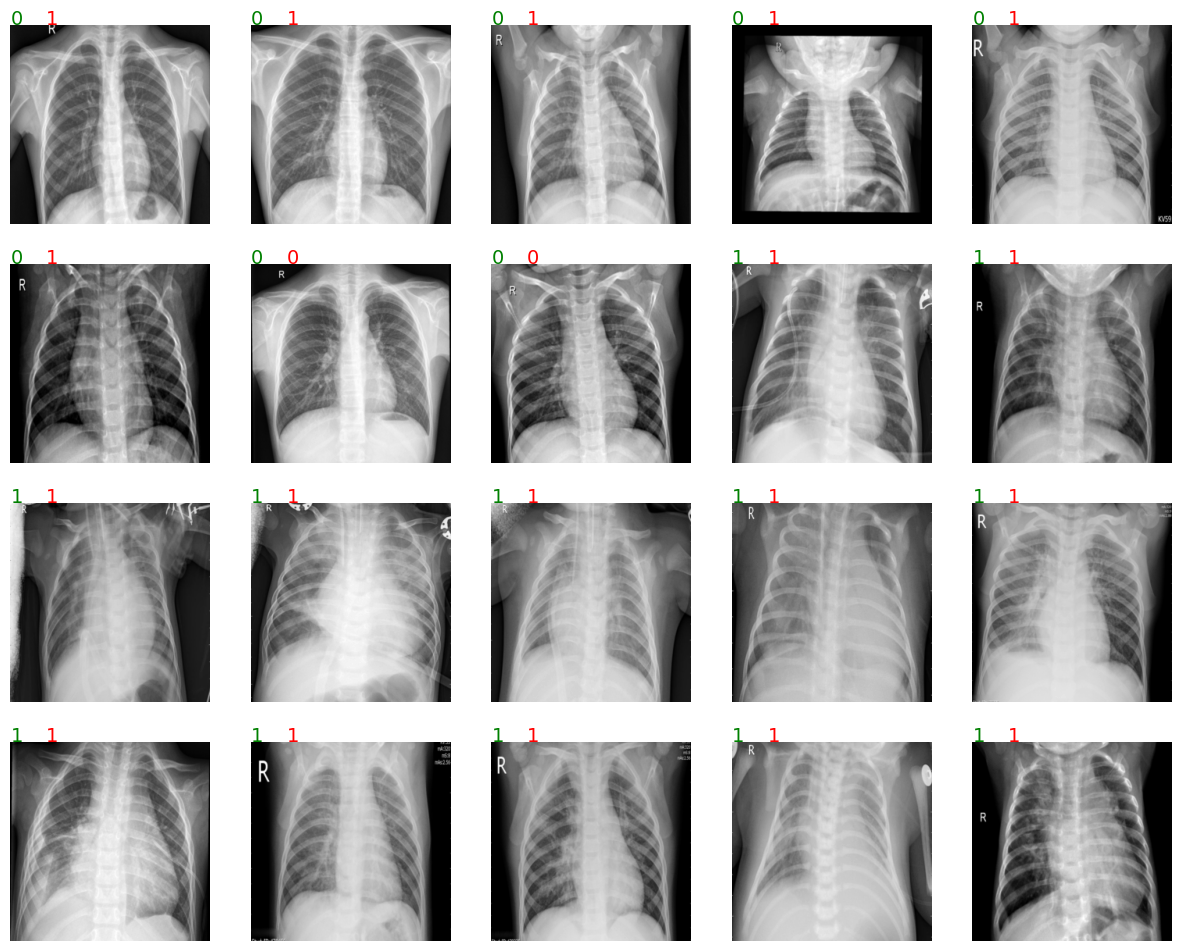

In [ ]:
showPredAndTrueLabels(vgg16_pre, test_loader)

###ResNet

ResNet **(Residual Network)** is a type of deep neural network architecture designed to tackle the vanishing gradient problem in very deep networks. ResNet-50 specifically has 50 layers and is widely used for various computer vision tasks.

In the pretrained version, the model is loaded with **weights pre-trained on a large dataset**. In the case of torchvision's ResNet-50, the pre-training is typically done on the ImageNet dataset, which consists of a large number of images spanning a wide range of categories.

In [ ]:
# load model from torchvision (with pretrained=True)
resnet = models.resnet50(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, 2)

resnet_pre = resnet.to(device)


In [ ]:
summary(resnet_pre, input_size=(3, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 128, 128]           9,408
       BatchNorm2d-2         [32, 64, 128, 128]             128
              ReLU-3         [32, 64, 128, 128]               0
         MaxPool2d-4           [32, 64, 64, 64]               0
            Conv2d-5           [32, 64, 64, 64]           4,096
       BatchNorm2d-6           [32, 64, 64, 64]             128
              ReLU-7           [32, 64, 64, 64]               0
            Conv2d-8           [32, 64, 64, 64]          36,864
       BatchNorm2d-9           [32, 64, 64, 64]             128
             ReLU-10           [32, 64, 64, 64]               0
           Conv2d-11          [32, 256, 64, 64]          16,384
      BatchNorm2d-12          [32, 256, 64, 64]             512
           Conv2d-13          [32, 256, 64, 64]          16,384
      BatchNorm2d-14          [32, 256,

In [ ]:
MODEL_NAME = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer = torch.optim.SGD(resnet.parameters(), lr = 0.001)

####Training the model

In [ ]:
NUM_EPOCHS = 30

resnet_train_history, resnet_val_history = train_model(NUM_EPOCHS, train_loader, val_loader, resnet, MODEL_NAME, loss_fn, optimizer, PATIENCE)

Start training...

Epoch 1/30


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


> Train loss: 0.367 	 Train acc: 0.842 	 Val loss: 0.238 	 Val acc: 0.931

Epoch 2/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.193 	 Train acc: 0.940 	 Val loss: 0.161 	 Val acc: 0.962

Epoch 3/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.144 	 Train acc: 0.952 	 Val loss: 0.123 	 Val acc: 0.966

Epoch 4/30


100%|██████████| 17/17 [00:19<00:00,  1.15s/it]


> Train loss: 0.116 	 Train acc: 0.961 	 Val loss: 0.106 	 Val acc: 0.964

Epoch 5/30


100%|██████████| 17/17 [00:10<00:00,  1.66it/s]


> Train loss: 0.091 	 Train acc: 0.969 	 Val loss: 0.088 	 Val acc: 0.973

Epoch 6/30


100%|██████████| 17/17 [00:10<00:00,  1.69it/s]


> Train loss: 0.083 	 Train acc: 0.972 	 Val loss: 0.083 	 Val acc: 0.971

Epoch 7/30


100%|██████████| 17/17 [00:10<00:00,  1.58it/s]


> Train loss: 0.073 	 Train acc: 0.976 	 Val loss: 0.076 	 Val acc: 0.967

Epoch 8/30


100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


> Train loss: 0.063 	 Train acc: 0.979 	 Val loss: 0.069 	 Val acc: 0.975

Epoch 9/30


100%|██████████| 17/17 [00:18<00:00,  1.08s/it]


> Train loss: 0.056 	 Train acc: 0.983 	 Val loss: 0.073 	 Val acc: 0.971

Epoch 10/30


100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


> Train loss: 0.045 	 Train acc: 0.987 	 Val loss: 0.064 	 Val acc: 0.971

Epoch 11/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.042 	 Train acc: 0.989 	 Val loss: 0.058 	 Val acc: 0.977

Epoch 12/30


100%|██████████| 17/17 [00:12<00:00,  1.32it/s]


> Train loss: 0.040 	 Train acc: 0.988 	 Val loss: 0.058 	 Val acc: 0.977

Epoch 13/30


100%|██████████| 17/17 [00:10<00:00,  1.58it/s]


> Train loss: 0.032 	 Train acc: 0.993 	 Val loss: 0.056 	 Val acc: 0.975

Epoch 14/30


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


> Train loss: 0.036 	 Train acc: 0.990 	 Val loss: 0.052 	 Val acc: 0.979

Epoch 15/30


100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


> Train loss: 0.026 	 Train acc: 0.994 	 Val loss: 0.052 	 Val acc: 0.979

Epoch 16/30


100%|██████████| 17/17 [00:09<00:00,  1.75it/s]


> Train loss: 0.023 	 Train acc: 0.995 	 Val loss: 0.050 	 Val acc: 0.981

Epoch 17/30


100%|██████████| 17/17 [00:10<00:00,  1.63it/s]


> Train loss: 0.020 	 Train acc: 0.996 	 Val loss: 0.047 	 Val acc: 0.983

Epoch 18/30


100%|██████████| 17/17 [00:10<00:00,  1.70it/s]


> Train loss: 0.024 	 Train acc: 0.994 	 Val loss: 0.045 	 Val acc: 0.985

Epoch 19/30


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


> Train loss: 0.016 	 Train acc: 0.997 	 Val loss: 0.049 	 Val acc: 0.979

Epoch 20/30


100%|██████████| 17/17 [00:10<00:00,  1.68it/s]


> Train loss: 0.015 	 Train acc: 0.998 	 Val loss: 0.042 	 Val acc: 0.989

Epoch 21/30


100%|██████████| 17/17 [00:09<00:00,  1.74it/s]


> Train loss: 0.015 	 Train acc: 0.997 	 Val loss: 0.052 	 Val acc: 0.977

Epoch 22/30


100%|██████████| 17/17 [00:10<00:00,  1.68it/s]


> Train loss: 0.013 	 Train acc: 0.998 	 Val loss: 0.043 	 Val acc: 0.981

Epoch 23/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.013 	 Train acc: 0.998 	 Val loss: 0.049 	 Val acc: 0.979

Epoch 24/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.008 	 Train acc: 0.999 	 Val loss: 0.040 	 Val acc: 0.985

Epoch 25/30


100%|██████████| 17/17 [00:10<00:00,  1.61it/s]


> Train loss: 0.012 	 Train acc: 0.998 	 Val loss: 0.041 	 Val acc: 0.985

Epoch 26/30


100%|██████████| 17/17 [00:09<00:00,  1.72it/s]


> Train loss: 0.009 	 Train acc: 0.999 	 Val loss: 0.042 	 Val acc: 0.983

Epoch 27/30


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.009 	 Train acc: 0.999 	 Val loss: 0.048 	 Val acc: 0.975

Epoch 28/30


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


> Train loss: 0.008 	 Train acc: 0.999 	 Val loss: 0.043 	 Val acc: 0.979

Epoch 29/30


100%|██████████| 17/17 [00:10<00:00,  1.59it/s]


> Train loss: 0.009 	 Train acc: 0.999 	 Val loss: 0.038 	 Val acc: 0.987

Epoch 30/30


100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


> Train loss: 0.007 	 Train acc: 1.000 	 Val loss: 0.039 	 Val acc: 0.983

Finished


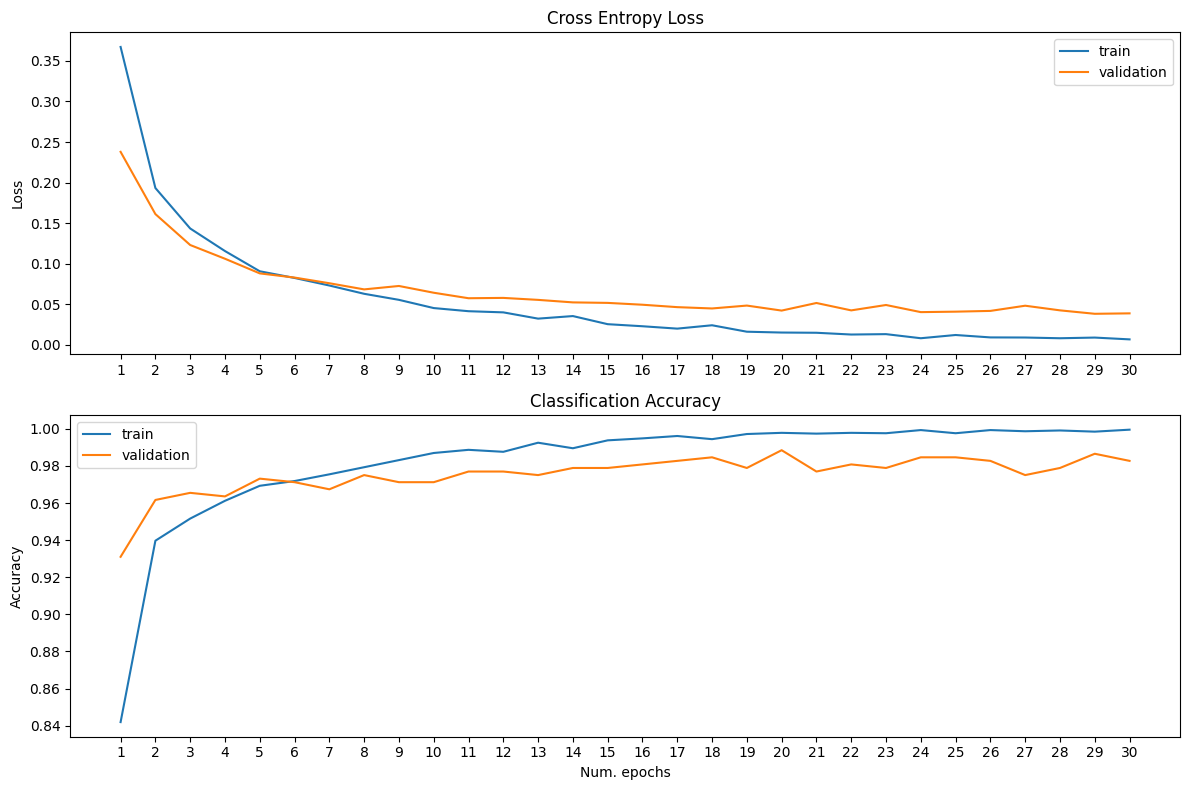

In [ ]:
plotTrainingHistory(resnet_train_history, resnet_val_history)

The training process concludes after 30 epochs.
 The model demonstrates exceptional performance with an **average train accuracy of 99.8%** and **a validation accuracy of 98.9%**, highlighting its strong learning capabilities during this training period.

Contrary to any observed stagnation in performance, these results offer valuable insights for further investigation. The data suggests that the model has achieved a high level of accuracy, indicating a robust understanding of the underlying patterns.



#### Testing ResNet

In [ ]:
# Load the model
resnet = resnet.to(device)
checkpoint = torch.load('best_model_resnet50.pth')
resnet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
test_metrics= epoch_iter(test_loader, resnet, loss_fn, is_train=False)
print(f"\nTest Loss: {test_metrics['loss']:.3f} \nTest Accuracy: {test_metrics['accuracy']:.3f} "
      f"\nTest Precision: {test_metrics['precision']:.3f} \nTest Recall: {test_metrics['recall']:.3f} "
      f"\nTest F1: {test_metrics['f1']:.3f}" )

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Test Loss: 0.691 
Test Accuracy: 0.814 
Test Precision: 0.854 
Test Recall: 0.814 
Test F1: 0.796


The **test accuracy of 81,4%** is generally positive, indicating that the model is performing well on the test set. The fact that the test accuracy **is lower than the validation accuracy can imply that the model is overfit the training data** meaning it has become too tailored to the training data and struggles to generalize to new, unseen data.

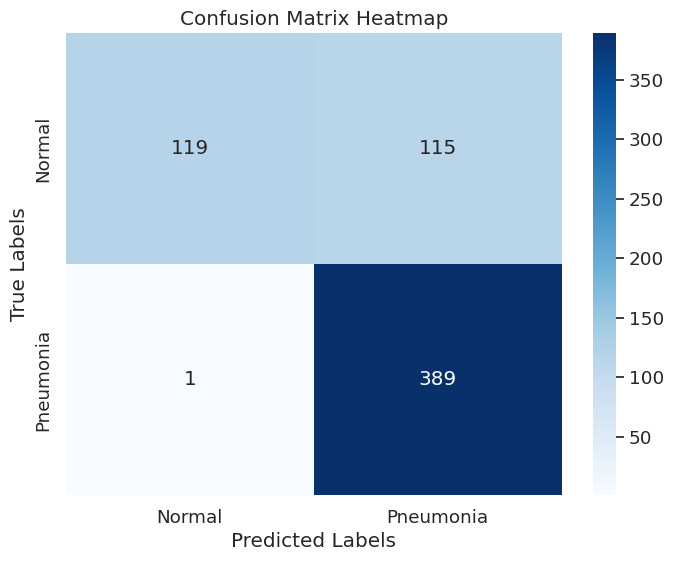

In [ ]:
class_names = [ "Normal", "Pneumonia"]
test_conf_matrix = test_metrics['conf_matrix']

plot_confusion_matrix(test_conf_matrix, class_names)

####Show predicted and true labels

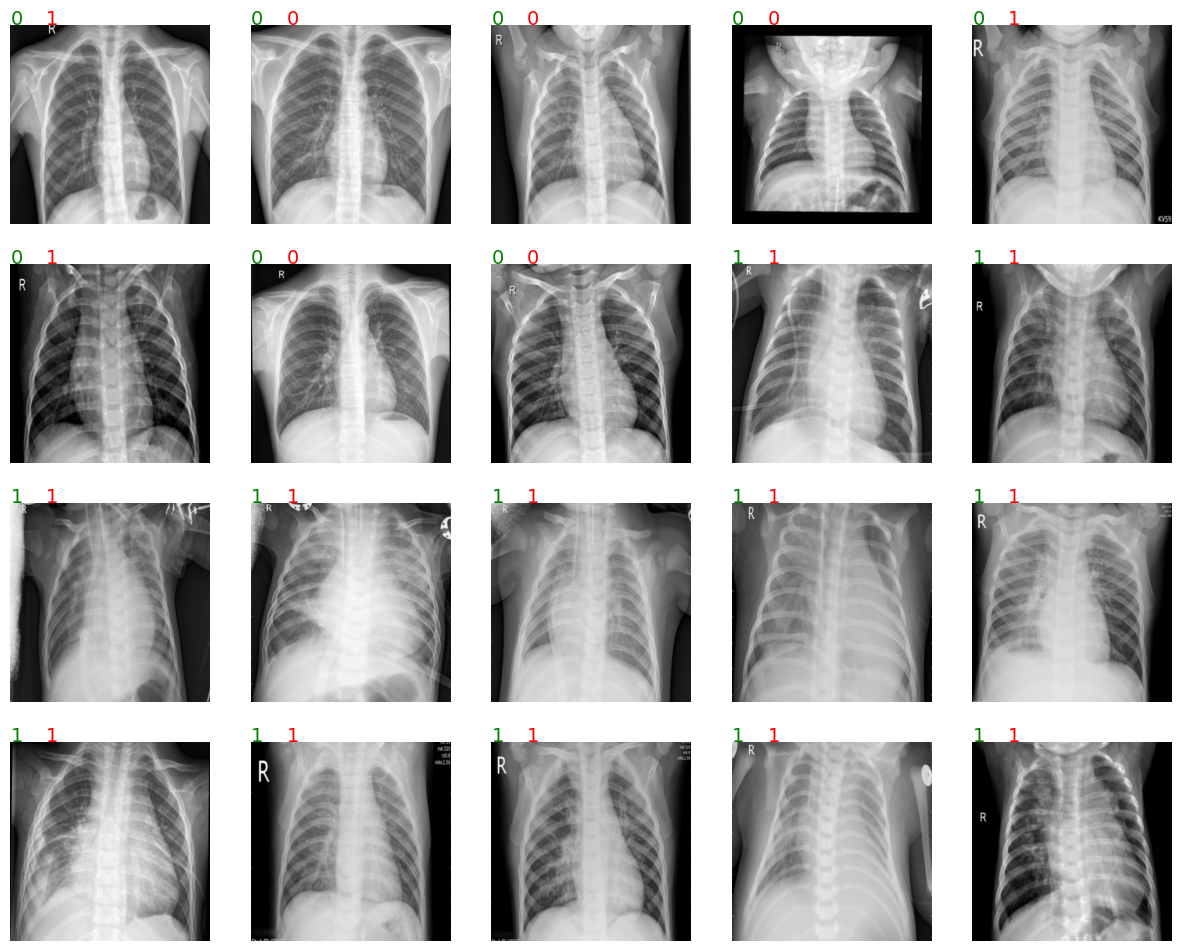

In [ ]:
showPredAndTrueLabels(resnet, test_loader)

###DenseNet

DenseNet, short for **Densely Connected Convolutional Networks**, is a deep learning architecture designed for image classification tasks. The key innovation of DenseNet is its dense connectivity pattern. In traditional convolutional neural networks (CNNs), each layer is connected only to the next layer in a sequential fashion. DenseNet, on the other hand, connects each layer to every other layer in a feed-forward fashion. This dense connectivity ensures a direct flow of information and gradients throughout the network, allowing for better feature reuse and more efficient learning.

DenseNet pretrained like the other pretrained models loads a version that has been pre-trained on a large dataset, often ImageNet.

In [ ]:
# Load pre-trained DenseNet model
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)

# Move the model to the device
densenet = densenet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(densenet.parameters(), lr=0.005, momentum=0.9)

#### Training DenseNet

In [ ]:
NUM_EPOCHS = 10
MODEL_NAME = 'densenet'
densenet_train_history, densenet_val_history = train_model(NUM_EPOCHS, train_loader, val_loader, densenet, MODEL_NAME, loss_fn, optimizer, PATIENCE)

Start training...

Epoch 1/10


100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


> Train loss: 0.110 	 Train acc: 0.956 	 Val loss: 0.034 	 Val acc: 0.989

Epoch 2/10


100%|██████████| 17/17 [00:10<00:00,  1.58it/s]


> Train loss: 0.030 	 Train acc: 0.990 	 Val loss: 0.041 	 Val acc: 0.994

Epoch 3/10


100%|██████████| 17/17 [00:10<00:00,  1.60it/s]


> Train loss: 0.020 	 Train acc: 0.993 	 Val loss: 0.033 	 Val acc: 0.994

Epoch 4/10


100%|██████████| 17/17 [00:10<00:00,  1.66it/s]


> Train loss: 0.009 	 Train acc: 0.997 	 Val loss: 0.038 	 Val acc: 0.994

Epoch 5/10


100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


> Train loss: 0.004 	 Train acc: 0.999 	 Val loss: 0.039 	 Val acc: 0.994

Epoch 6/10


100%|██████████| 17/17 [00:10<00:00,  1.62it/s]


> Train loss: 0.003 	 Train acc: 1.000 	 Val loss: 0.025 	 Val acc: 0.996

Epoch 7/10


100%|██████████| 17/17 [00:10<00:00,  1.62it/s]


> Train loss: 0.001 	 Train acc: 0.999 	 Val loss: 0.055 	 Val acc: 0.983

Epoch 8/10


100%|██████████| 17/17 [00:10<00:00,  1.62it/s]


> Train loss: 0.001 	 Train acc: 1.000 	 Val loss: 0.027 	 Val acc: 0.994

Epoch 9/10


100%|██████████| 17/17 [00:10<00:00,  1.63it/s]


> Train loss: 0.000 	 Train acc: 1.000 	 Val loss: 0.025 	 Val acc: 0.996

Epoch 10/10


100%|██████████| 17/17 [00:10<00:00,  1.64it/s]


> Train loss: 0.000 	 Train acc: 1.000 	 Val loss: 0.024 	 Val acc: 0.992

Finished


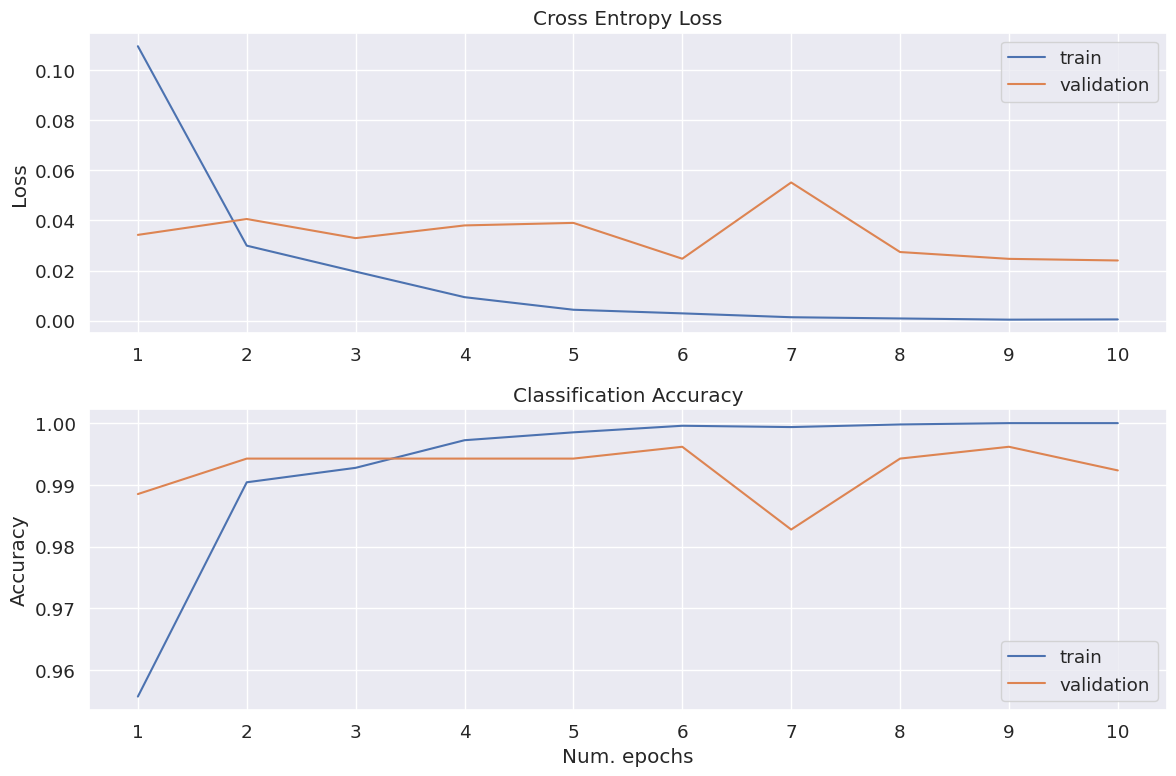

In [ ]:
plotTrainingHistory(densenet_train_history, densenet_val_history)

The outcomes from our model are highly favorable and promising on the whole. Our model is demonstrating commendable performance after ten epochs.

We've attained a remarkable **training accuracy of 100% with a validation accuracy of 99.2%**, underscoring the model's adeptness at learning from the training dataset and successfully generalizing to previously unseen data.

#### Testing DenseNet

In [ ]:
# Load the model
densenet = densenet.to(device)
checkpoint = torch.load('best_model_densenet.pth')
densenet.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
test_metrics= epoch_iter(test_loader, densenet, loss_fn, is_train=False)
print(f"\nTest Loss: {test_metrics['loss']:.3f} \nTest Accuracy: {test_metrics['accuracy']:.3f} "
      f"\nTest Precision: {test_metrics['precision']:.3f} \nTest Recall: {test_metrics['recall']:.3f} "
      f"\nTest F1: {test_metrics['f1']:.3f}" )

100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


Test Loss: 1.118 
Test Accuracy: 0.851 
Test Precision: 0.880 
Test Recall: 0.851 
Test F1: 0.840


The **test accuracy of 85,1%** is generally positive, indicating that the model is performing well on the test set. The fact that the test accuracy **is lower than the validation accuracy can imply that the model is overfit the training data** meaning it has become too tailored to the training data and struggles to generalize to new, unseen data.

It's essential to strike a balance between achieving high accuracy on the training data and ensuring the model's ability to generalize to new instances, due to the fact of the low number of epochs trained.

Regularization techniques or adjusting model complexity might be considered to address overfitting.

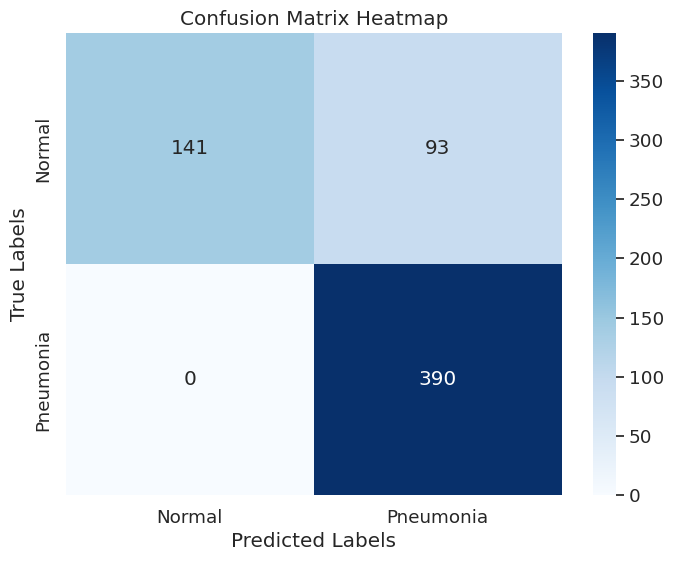

In [ ]:
class_names = [ "Normal", "Pneumonia"]
test_conf_matrix = test_metrics['conf_matrix']

plot_confusion_matrix(test_conf_matrix, class_names)

####Show predicted and true labels

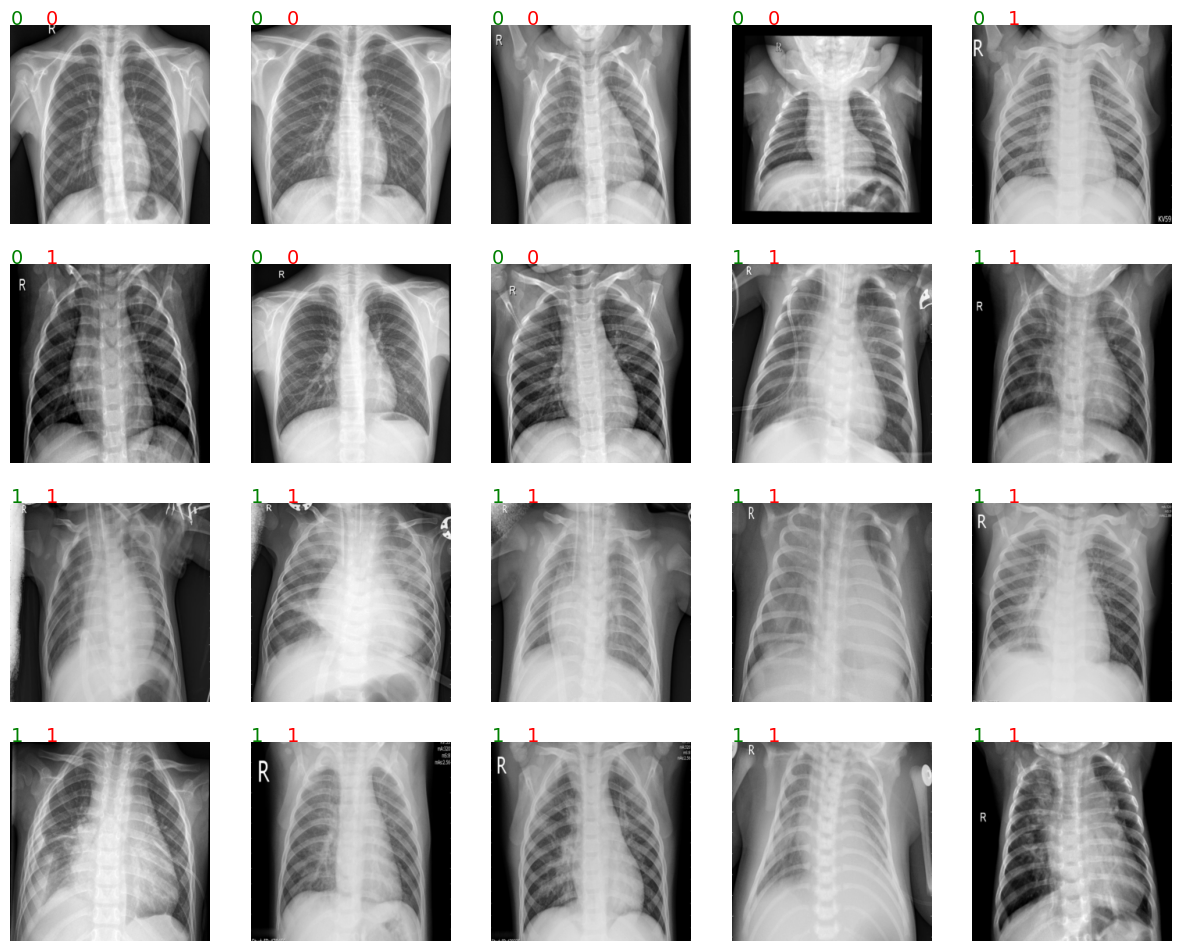

In [ ]:
showPredAndTrueLabels(densenet, test_loader)

##Results

In [2]:
values = [
    {'Model': 'AutoEncoder', 'Number of epochs': 10,  'Train Accuracy': 85.9, 'Validation Accuracy': 87.1, 'Test Accuracy': 81.7, 'Train Loss': 0.3327, 'Validation Loss': 0.3247, 'Test Loss': 0.4562, 'Test Precision': 80.53, 'Test Recall': 93.3, 'Test F1': 86.46, 'Trainable params': 1003605779, 'Non-Trainable params': 0},
    {'Model': 'VAE', 'Number of epochs': 10,  'Train Accuracy': 76.9, 'Validation Accuracy': 79.8, 'Test Accuracy': 65.2, 'Train Loss': 0.4835, 'Validation Loss': 0.4806, 'Test Loss': 0.7136, 'Test Precision': 66.48, 'Test Recall': 89.49, 'Test F1': 76.28, 'Trainable params': 121242736, 'Non-Trainable params': 0},
    {'Model': 'CNN', 'Number of epochs': 30,  'Train Accuracy': 98.1, 'Validation Accuracy': 97.9, 'Test Accuracy': 72.1, 'Train Loss': 0.052, 'Validation Loss': 0.067, 'Test Loss': 1.418, 'Test Precision': 79.6, 'Test Recall': 72.1, 'Test F1': 66.7, 'Trainable params': 19578946,'Non-Trainable params': 0},
    {'Model': 'VGG', 'Number of epochs': 30,  'Train Accuracy': 95.2, 'Validation Accuracy': 96.9, 'Test Accuracy': 72.9, 'Train Loss': 0.142, 'Validation Loss': 0.089, 'Test Loss': 0.836, 'Test Precision': 78.8, 'Test Recall': 72.9, 'Test F1': 68.2, 'Trainable params': 134268738, 'Non-Trainable params': 0},
    {'Model': 'ResNet', 'Number of epochs': 30,  'Train Accuracy': 99.9, 'Validation Accuracy': 98.7, 'Test Accuracy': 81.4, 'Train Loss': 0.009, 'Validation Loss': 0.038,'Test Loss': 0.691, 'Test Precision': 85.40, 'Test Recall': 81.40, 'Test F1': 79.60, 'Trainable params': 23512130, 'Non-Trainable params': 0},
    {'Model': 'DenseNet', 'Number of epochs': 10,  'Train Accuracy': 100, 'Validation Accuracy': 99.2, 'Test Accuracy': 85.1, 'Train Loss': 0.003, 'Validation Loss': 0.024,'Test Loss': 1.118, 'Test Precision': 88.0, 'Test Recall': 85.1, 'Test F1': 84.0, 'Trainable params': 4022920, 'Non-Trainable params': 0}
]

results = pd.DataFrame(values)
results

Model  Number of epochs  Train Accuracy  Validation Accuracy  \
0  AutoEncoder                10            85.9                 87.1   
1          VAE                10            76.9                 79.8   
2          CNN                30            98.1                 97.9   
3          VGG                30            95.2                 96.9   
4       ResNet                30            99.9                 98.7   
5     DenseNet                10           100.0                 99.2   

   Test Accuracy  Train Loss  Validation Loss  Test Loss  Test Precision  \
0           81.7      0.3327           0.3247     0.4562           80.53   
1           65.2      0.4835           0.4806     0.7136           66.48   
2           72.1      0.0520           0.0670     1.4180           79.60   
3           72.9      0.1420           0.0890     0.8360           78.80   
4           81.4      0.0090           0.0380     0.6910           85.40   
5           85.1      0.0030           0.0240     1.1180           88.00   

   Test Recall  Test F1  Trainable params  Non-Trainable params  
0        93.30    86.46        1003605779                     0  
1        89.49    76.28         121242736                     0  
2        72.10    66.70          19578946                     0  
3        72.90    68.20         134268738                     0  
4        81.40    79.60          23512130                     0  
5        85.10    84.00           4022920                     0

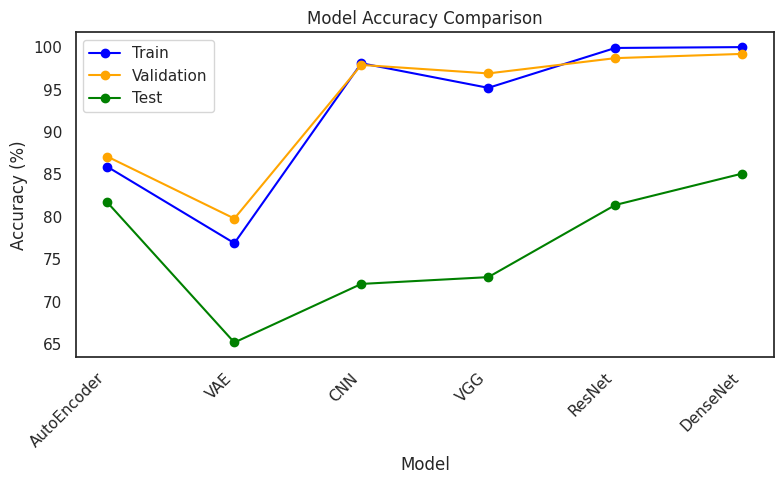

In [3]:
# Set the style of seaborn to white background without grid lines
sns.set(style="white")

plt.figure(figsize=(8, 5))

# Plot lines for Train Accuracy
plt.plot(results['Model'], results['Train Accuracy'], marker='o', label='Train', linestyle='-', color='blue')

# Plot lines for Validation Accuracy
plt.plot(results['Model'], results['Validation Accuracy'], marker='o', label='Validation', linestyle='-', color='orange')

# Plot lines for Test Accuracy
plt.plot(results['Model'], results['Test Accuracy'], marker='o', label='Test', linestyle='-', color='green')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

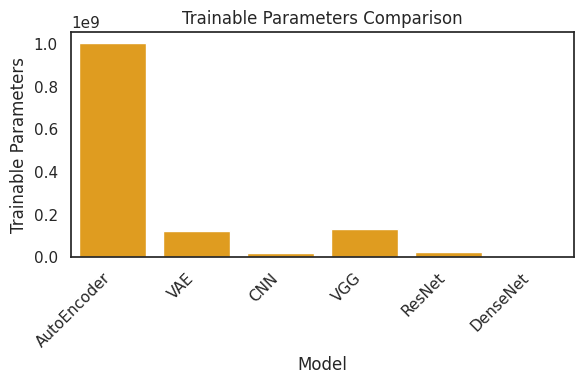

In [ ]:
# Create bar chart for Trainable params
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Trainable params', data=results, color='orange')
plt.title('Trainable Parameters Comparison')
plt.ylabel('Trainable Parameters')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusion


Diagnosing pneumonia, or a respiratory infection characterized by inflammation of the lung tissue, is a critical task for
healthcare professionals. Traditional diagnosis relies heavily
on interpreting chest X-rays, which can be complex and
subtle, requiring expertise and experience. Different doctors
may interpret X-rays differently due to variations in experience, expertise, and subjective judgment. They often deal
with a large volume of medical imaging data, making it
challenging to analyze and interpret efficiently. Also, manual
analysis and interpretation of medical images can be time-
consuming, especially when doctors are dealing with many
cases simultaneously.

With this project, the goal was to automatically analyze
and interpret medical images, providing a faster and more
consistent approach to detecting abnormalities in chest X-rays
and we tried different approaches.

The AutoEncoder, despite a slight drop in testing accuracy to 81.7%, excelled in recall (93.33%), making it highly efficient in identifying relevant cases. The VAE, while having lower accuracy and precision, also performed well in recall. In contrast, despite high training accuracies, the CNN and VGG16 models suffered from overfitting, as evidenced by their reduced testing performance. ResNet emerged as the most effective. DenseNet stood out with a high testing accuracy of 85.1%, showcasing excellent precision and recall ,but the hight accuracy in trainning might incicate overffiting. ResNet also showed strong performance with a testing accuracy of 81.4% and balanced precision and recall, indicating its reliability.

Therefore we can conclude that this analysis suggests that DenseNet and
ResNet are more suitable for balanced performance across
various metrics, especially in minimizing false positives. At
the same time, AutoEncoder and VAE are preferable for
projects prioritizing high recall rates.

In conclusion, our exploration of various deep-learning
models highlights the trade-offs between precision, recall,
and accuracy in medical image analysis. The results indicate
that while models like DenseNet and ResNet offer balanced
and robust performance, nevertheless the choice of model
should ultimately be guided by the specific requirements of
the medical imaging task, such as the preference for either
minimizing false positives (precision) or maximizing the detection of relevant cases (recall). With this project, we hope
to contribute valuable insights into applying deep learning in
medical imaging, paving the way for more advanced, reliable,
and efficient diagnostic tools.

It’s important to note that these models should be used as
decision support tools, and qualified healthcare professionals
should always confirm the final diagnosis. Additionally, ethical considerations, data privacy, and model interpretability
are essential aspects that must be carefully addressed in
deploying deep learning models in healthcare settings.

Therefore for future work, we propose enhancing our
AI models for diagnosing pneumonia from chest X-rays.
This can include the enhancement of hyperparameters, using
advanced deep learning architectures, or hybrid models that
can combine strengths with the ones used in this project.
Expanding, diversifying the dataset, and focusing on data
augmentation should be another goal. Plans to make these
models interpretable for healthcare professionals, conduct
real-world clinical trials integrating them into healthcare IT
systems, and try to adapt them for use in low-resource
settings should also be considered.

Another suggestion is to extend the technologies for detecting multiple lung diseasesin compliance with ethical and privacy concerns. Compliance, including collaboration with medical experts, should
be a goal to get more reliable results and improvements.
Regardless, and finally, continuous monitoring of the model’s
long-term performance is essential for ensuring reliability
and accuracy.